#Blood suger prediction using NHITS

In [1]:
%%capture
! pip install statsforecast s3fs datasetsforecast

In [2]:
%%capture
! pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [14]:
import pandas as pd
import numpy as np
import os
import random

from statsforecast import StatsForecast
import matplotlib.pyplot as plt

In [16]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os
import json

import plotly.graph_objects as go
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 2. Read the data

The input to `NeuralForecast` is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.
We will rename the


In [3]:
!wget -P Data https://raw.githubusercontent.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/refs/heads/main/Data/train_multi_no_gaps.csv
!wget -P Data https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/test_multi_no_gaps.csv
!wget -P Data https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/test_p27_no_gaps.csv
!wget -P Data https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/train_p27_no_gaps.csv


--2025-02-19 23:51:52--  https://raw.githubusercontent.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/refs/heads/main/Data/train_multi_no_gaps.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19414820 (19M) [text/plain]
Saving to: ‘Data/train_multi_no_gaps.csv’

train_multi_no_gaps 100%[===================>]  18.51M  --.-KB/s    in 0.05s   

2025-02-19 23:51:54 (381 MB/s) - ‘Data/train_multi_no_gaps.csv’ saved [19414820/19414820]

--2025-02-19 23:51:54--  https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/test_multi_no_gaps.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting res

In [6]:
data_path=r'Data'
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

train_multi = pd.read_csv(os.path.join(data_path,'train_multi_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S")#, index_col="time")
test_multi = pd.read_csv(os.path.join(data_path,'test_multi_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S") #sep=';', date_format="%Y-%m-%dT%H:%M:%S", index_col="time")
train_p27 = pd.read_csv(os.path.join(data_path,'train_p27_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S") #sep=';', date_format="%Y-%m-%dT%H:%M:%S", index_col="time")
test_p27 = pd.read_csv(os.path.join(data_path,'test_p27_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S") #sep=';', date_format="%Y-%m-%dT%H:%M:%S", index_col="time")

test_p27 = test_p27.drop(columns={'old_time'})
train_p27 = train_p27.drop(columns={'old_time'})
test_multi = test_multi.drop(columns={'old_time'})
train_multi = train_multi.drop(columns={'old_time'})
#test_p27=test_p27.rename(columns={'old_time': 'time'})
#train_p27=train_p27.rename(columns={'old_time': 'time'})

train_multi['time'] = pd.to_datetime(train_multi['time'])
test_multi['time'] = pd.to_datetime(test_multi['time'])
train_p27['time'] = pd.to_datetime(train_p27['time'])
test_p27['time'] = pd.to_datetime(test_p27['time'])


In [9]:
train_multi

,time,subj,glucose,burned_calories,heart_rate,basal_insulin,bolus_insulin,time_of_day,hour_sin,hour_cos,heart_rate_imp,glucose_imp
0,2018-06-13 18:45:00,P01,329.333333,7.72800,83.740157,0.091667,0.0,18.75,-9.807853e-01,0.195090,83.740157,329.333333
1,2018-06-13 18:50:00,P01,326.666667,4.74950,80.525180,0.091667,0.0,18.83,-9.764845e-01,0.215588,80.525180,326.666667
2,2018-06-13 18:55:00,P01,320.000000,6.35950,89.129032,0.091667,0.0,18.92,-9.711343e-01,0.238533,89.129032,320.000000
3,2018-06-13 19:00:00,P01,314.333333,5.15200,92.495652,0.075000,0.0,19.00,-9.659258e-01,0.258819,92.495652,314.333333
4,2018-06-13 19:05:00,P01,310.333333,6.60100,92.000000,0.075000,0.0,19.08,-9.602937e-01,0.278991,92.000000,310.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
112667,2022-05-17 11:55:00,P28,109.333333,10.79280,104.171171,0.000000,0.0,11.92,2.094242e-02,-0.999781,104.171171,109.333333
112668,2022-05-17 12:00:00,P28,114.000000,9.80346,103.442623,0.000000,0.0,12.00,1.224647e-16,-1.000000,103.442623,114.000000
112669,2022-05-17 12:05:00,P28,118.666667,5.66622,95.542857,0.000000,0.0,12.08,-2.094242e-02,-0.999781,95.542857,118.666667
112670,2022-05-17 12:10:00,P28,123.333333,5.57628,91.381356,0.000000,0.0,12.17,-4.449120e-02,-0.999010,91.381356,123.333333


In [10]:
# Rename the columns to fit the desired format
train_multi_renamed = train_multi.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})

# Display the transformed DataFrame
print(train_multi_renamed[['unique_id','ds', 'y' ]])


       unique_id                  ds           y
0            P01 2018-06-13 18:45:00  329.333333
1            P01 2018-06-13 18:50:00  326.666667
2            P01 2018-06-13 18:55:00  320.000000
3            P01 2018-06-13 19:00:00  314.333333
4            P01 2018-06-13 19:05:00  310.333333
...          ...                 ...         ...
112667       P28 2022-05-17 11:55:00  109.333333
112668       P28 2022-05-17 12:00:00  114.000000
112669       P28 2022-05-17 12:05:00  118.666667
112670       P28 2022-05-17 12:10:00  123.333333
112671       P28 2022-05-17 12:15:00  128.000000

[112672 rows x 3 columns]


In [11]:
train_multi_glucose=train_multi_renamed[['unique_id','ds', 'y' ]]

In [12]:
# Rename the columns to fit the desired format
test_multi_renamed = test_multi.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})

# Display the transformed DataFrame
print(test_multi_renamed[['unique_id','ds', 'y' ]])

test_multi_glucose=test_multi_renamed[['unique_id','ds', 'y' ]]

      unique_id                  ds           y
0           P06 2018-07-09 15:45:00  109.000000
1           P06 2018-07-09 15:50:00  107.666667
2           P06 2018-07-09 15:55:00  106.333333
3           P06 2018-07-09 16:00:00  105.000000
4           P06 2018-07-09 16:05:00  122.333333
...         ...                 ...         ...
20011       P21 2019-07-11 15:15:00  148.000000
20012       P21 2019-07-11 15:20:00  148.666667
20013       P21 2019-07-11 15:25:00  149.333333
20014       P21 2019-07-11 15:30:00  150.000000
20015       P21 2019-07-11 15:35:00  156.000000

[20016 rows x 3 columns]


## 3. Explore Data with the plot method of StatsForecast

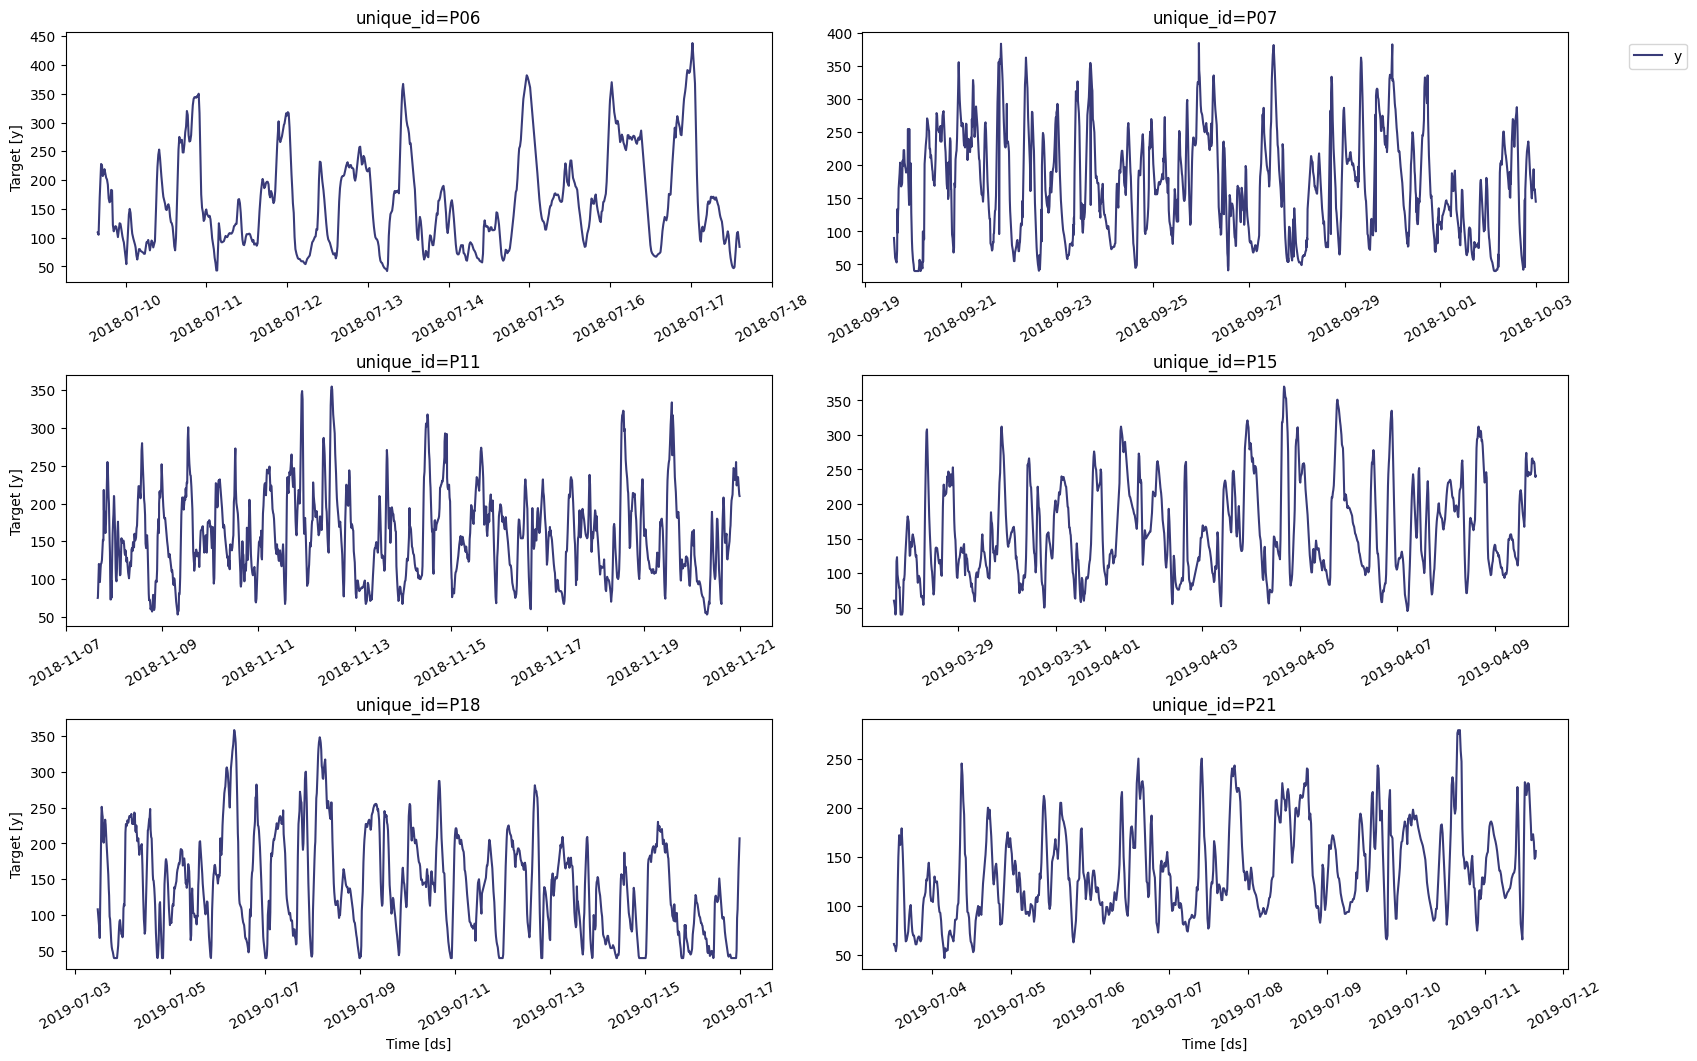

In [15]:
StatsForecast.plot(test_multi_renamed, engine='matplotlib')

## 4. Train multiple models for many series


In [17]:
config_nhits = {
    "input_size": tune.choice([24, 24*2, 24*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}
config_lstm = {
    "input_size": tune.choice([24, 24*2, 24*3]),#[48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}



To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm (from `tune.search`), default is random search. Refer to https://docs.ray.io/en/latest/tune/api_docs/suggestion.html for more information on the different search algorithm options.
* `num_samples`: number of configurations explored.


In [18]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=12, config=config_nhits, loss=MQLoss(), num_samples=5),
        #AutoLSTM(h=12, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq='5min'
)

In [ ]:
%%capture
nf.fit(df=train_multi_glucose)

2025-01-28 10:48:17,929	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-01-28_10-45-34' in 0.0086s.
INFO:lightning_fabric.utilities.seed:Seed set to 11
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 77.5 K | train
-------------------------------------------------------
77.5 K    Trainable params
5    

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
0,P01,2018-06-27 23:55:00,324.480713,317.283142,320.063751,328.511627,329.983307
1,P01,2018-06-28 00:00:00,324.494781,314.152435,317.637207,330.550293,332.970337
2,P01,2018-06-28 00:05:00,323.559631,305.798920,311.037994,334.759491,339.694061
3,P01,2018-06-28 00:10:00,322.460236,298.096954,305.364136,337.983429,345.199493
4,P01,2018-06-28 00:15:00,322.159851,293.138763,302.361847,340.090332,348.736877


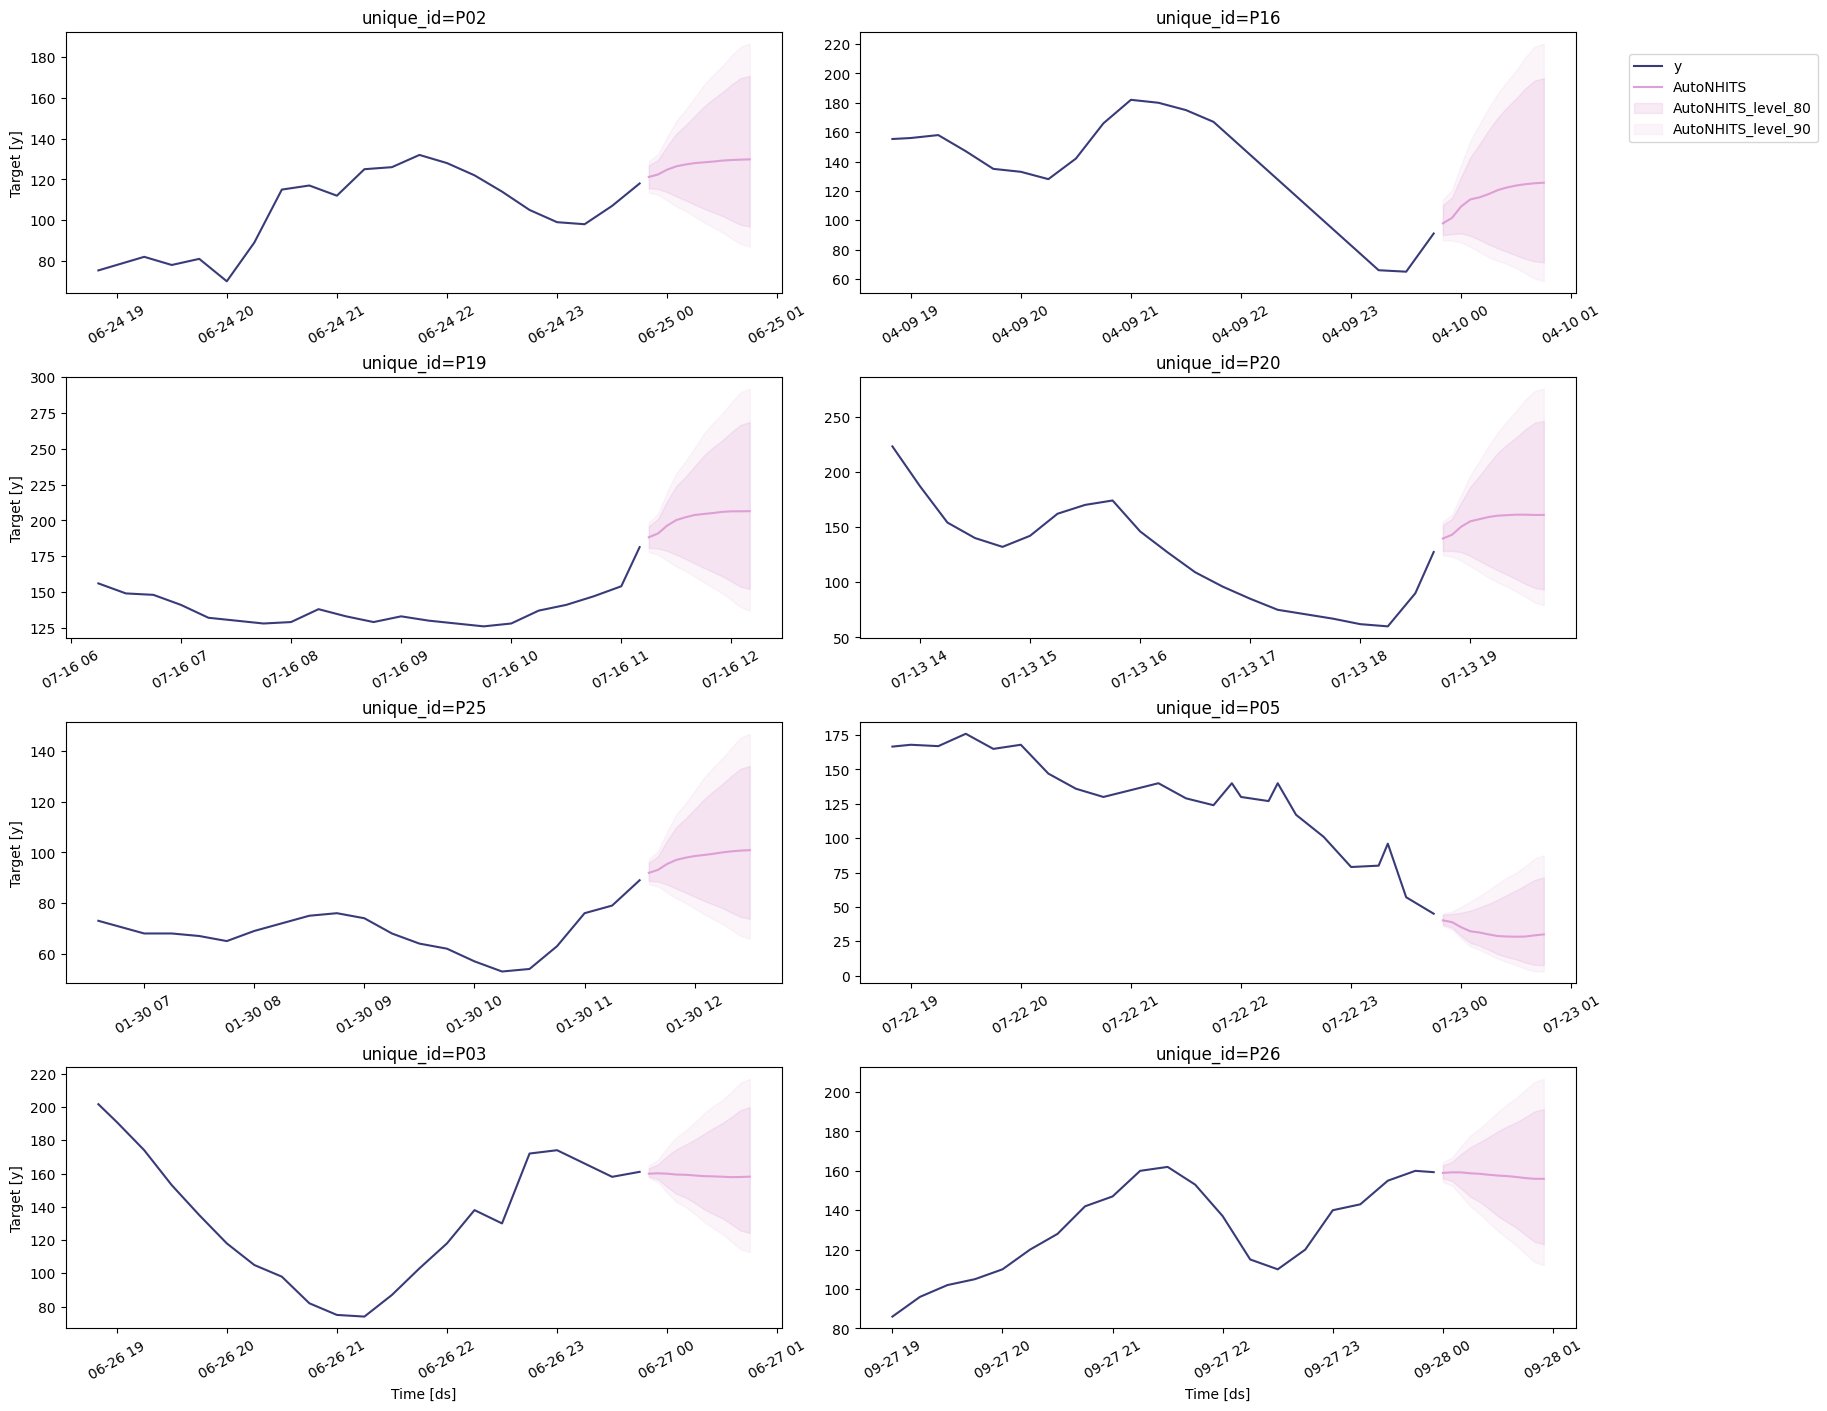

In [ ]:
StatsForecast.plot(train_multi_glucose, fcst_df, engine='matplotlib', max_insample_length=12 * 5, level=[80, 90])

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90
0,P01,2018-06-27 23:55:00,324.480713,317.283142,320.063751,328.511627,329.983307,160.973221,80.076736,89.917191,240.373962,273.828247
1,P01,2018-06-28 00:00:00,324.494781,314.152435,317.637207,330.550293,332.970337,161.083252,80.747177,89.469429,239.792816,273.059998
2,P01,2018-06-28 00:05:00,323.559631,305.798920,311.037994,334.759491,339.694061,161.131958,80.928535,89.783318,240.338654,272.544403
3,P01,2018-06-28 00:10:00,322.460236,298.096954,305.364136,337.983429,345.199493,161.120468,81.518669,90.605164,240.244934,272.758484
4,P01,2018-06-28 00:15:00,322.159851,293.138763,302.361847,340.090332,348.736877,160.930313,80.142319,88.820511,240.009125,271.802887


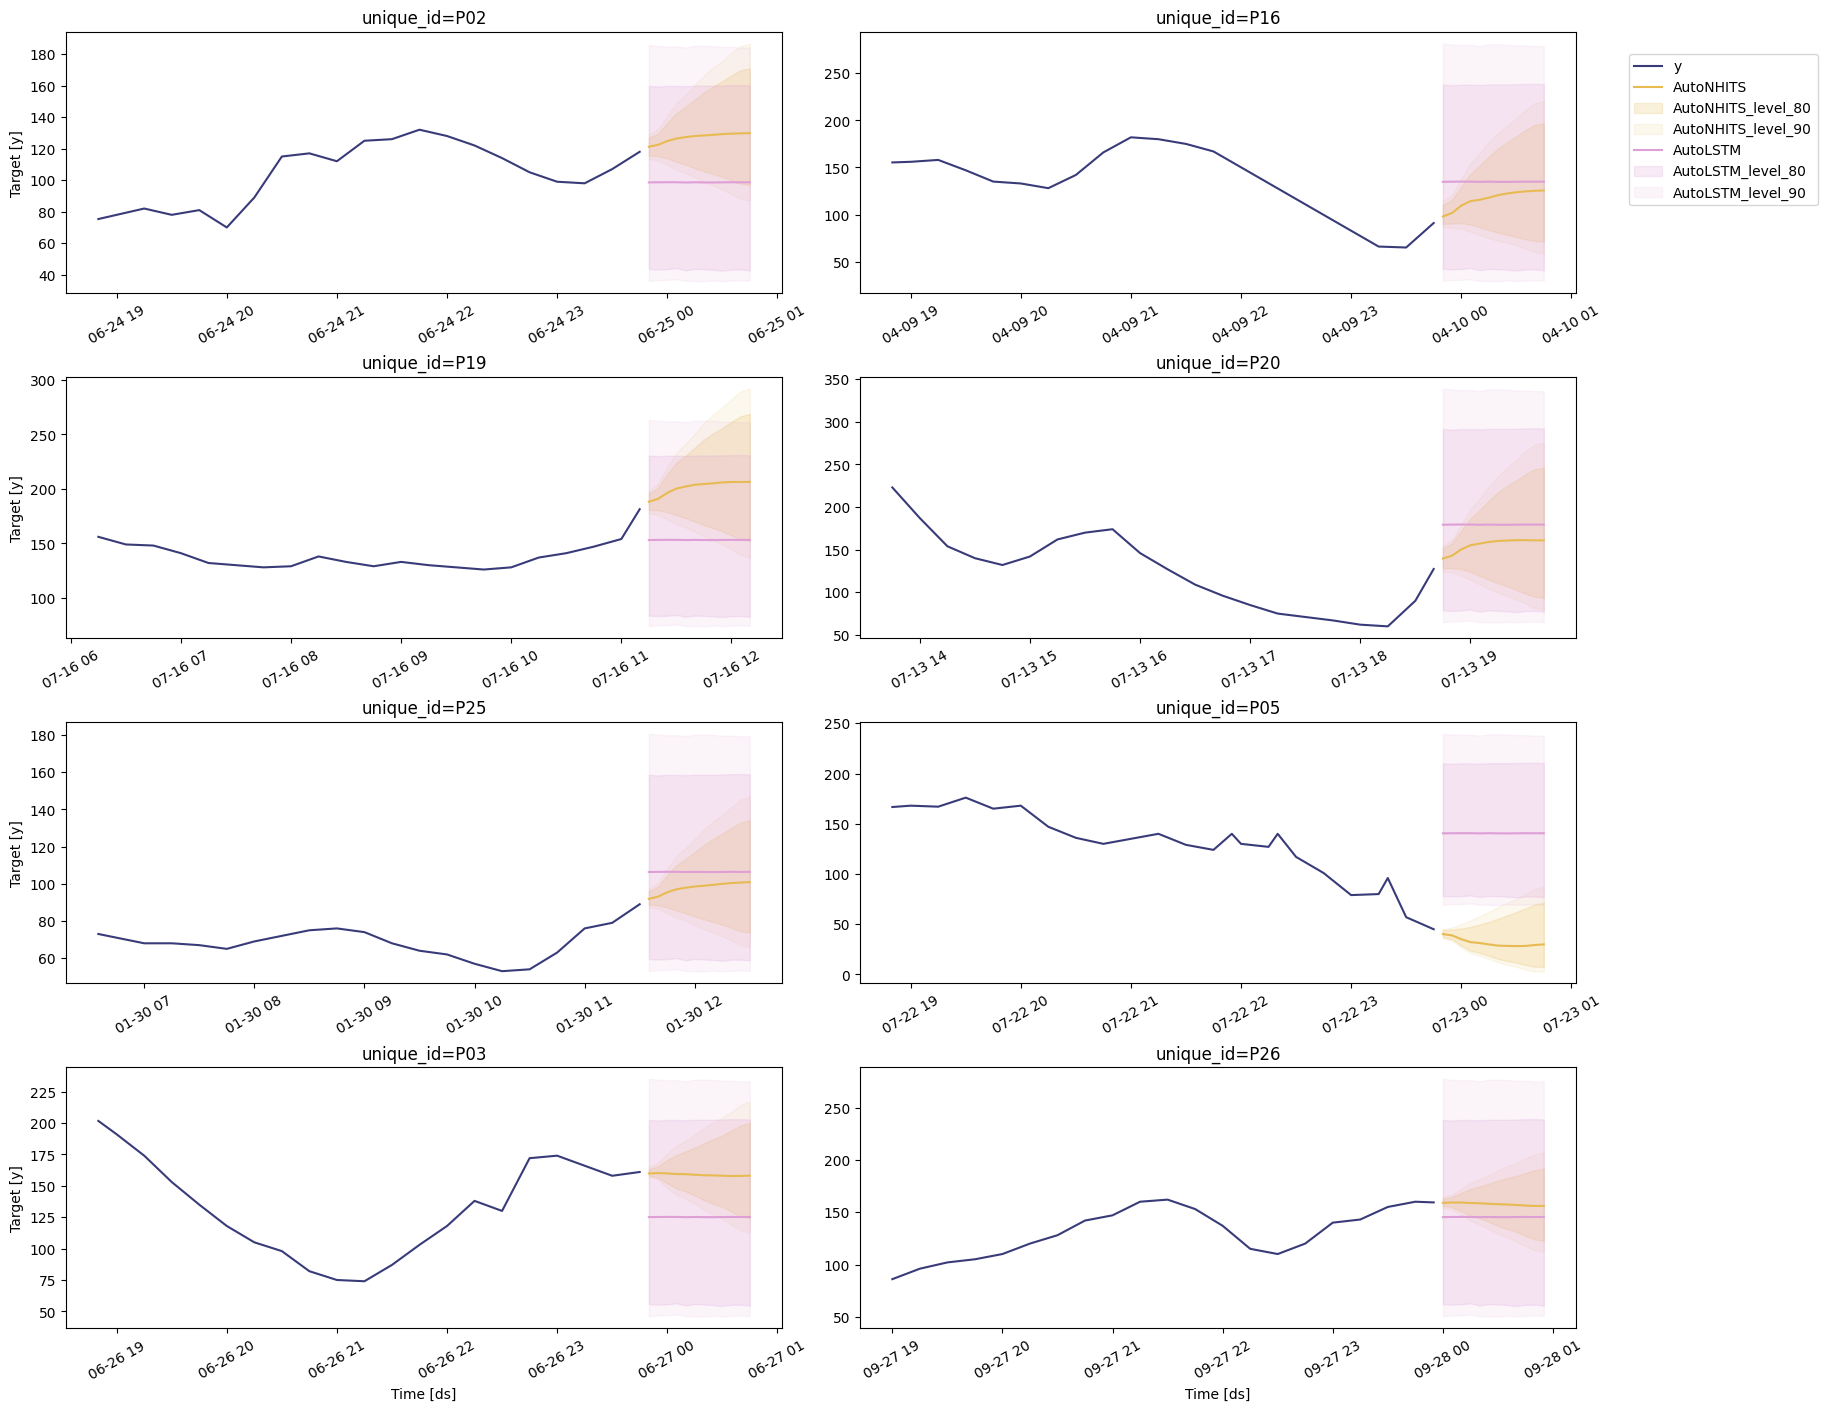

In [ ]:
StatsForecast.plot(train_multi_glucose, fcst_df, engine='matplotlib', max_insample_length=12 * 5, level=[80, 90])

In [ ]:
fcst_df[fcst_df['unique_id']=='P01']

,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
0,P01,2018-06-27 23:55:00,324.480713,317.283142,320.063751,328.511627,329.983307
1,P01,2018-06-28 00:00:00,324.494781,314.152435,317.637207,330.550293,332.970337
2,P01,2018-06-28 00:05:00,323.559631,305.798920,311.037994,334.759491,339.694061
3,P01,2018-06-28 00:10:00,322.460236,298.096954,305.364136,337.983429,345.199493
4,P01,2018-06-28 00:15:00,322.159851,293.138763,302.361847,340.090332,348.736877
5,P01,2018-06-28 00:20:00,321.232910,287.157501,297.781891,342.492371,352.911224
6,P01,2018-06-28 00:25:00,320.209229,280.514252,291.985779,345.570953,357.727539
7,P01,2018-06-28 00:30:00,319.406738,274.212494,287.142700,348.030396,361.919250
8,P01,2018-06-28 00:35:00,318.295563,267.890991,282.891266,349.489349,365.481445
9,P01,2018-06-28 00:40:00,316.861145,260.350830,277.080078,352.308655,370.050171


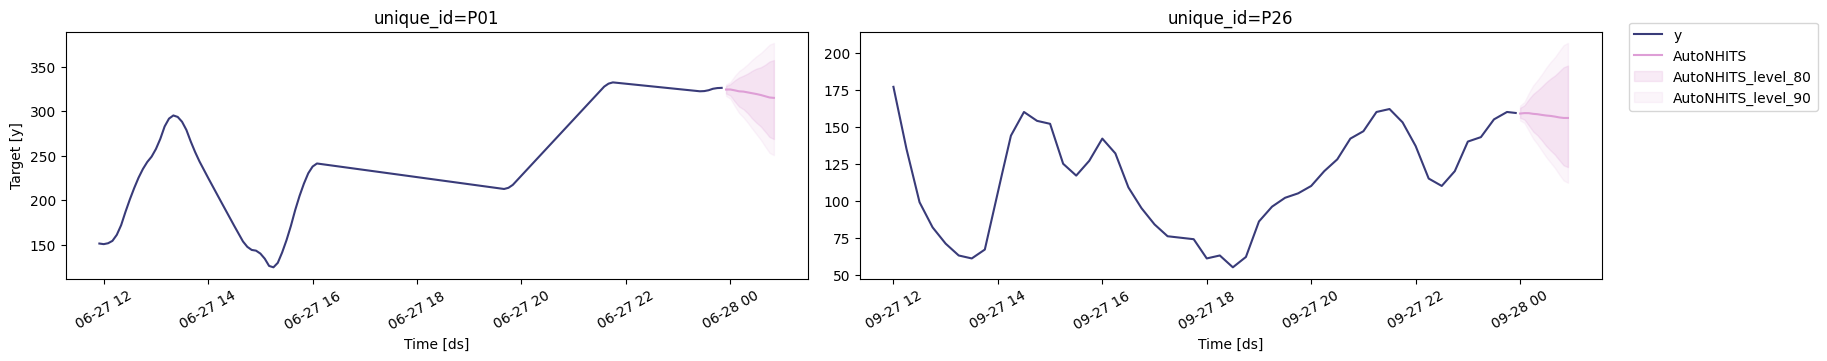

In [ ]:
StatsForecast.plot(train_multi_glucose, fcst_df, models=["AutoNHITS"], unique_ids=["P01", "P26"],max_insample_length=48 * 3, level=[80, 90], engine='matplotlib')


In [ ]:
test_multi_glucose['unique_id'].unique()

array(['P06', 'P07', 'P11', 'P15', 'P18', 'P21'], dtype=object)

## 5. Evaluate the model's performance


The `cross_validation` method from the `NeuralForecast` class takes the following arguments.

- `df`: training data frame

- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.


In [22]:
from neuralforecast.auto import AutoNHITS, AutoLSTM
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq=1
)

In [ ]:
%%capture
cv_df = nf.cross_validation(Y_df, n_windows=2)

2025-01-06 21:04:45,894	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-01-06_20-58-52' in 0.0185s.
INFO:lightning_fabric.utilities.seed:Seed set to 17
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 100 K  | train
-------------------------------------------------------
100 K     Trainable params
5         Non-trainable params
100 K     Total params
0.401     Total estimated model params 

In [ ]:
%%capture
cv_df = nf.cross_validation(train_multi_glucose, n_windows=12)

2025-01-28 11:12:30,625	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-01-28_11-09-50' in 0.0135s.
INFO:lightning_fabric.utilities.seed:Seed set to 11
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 77.5 K | train
-------------------------------------------------------
77.5 K    Trainable params
5    

The `cv_df` object is a new data frame that includes the following columns:

- `unique_id`: identifies each time series
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
cv_df.columns

Index(['unique_id', 'ds', 'cutoff', 'AutoNHITS-median', 'AutoNHITS-lo-90',
       'AutoNHITS-lo-80', 'AutoNHITS-hi-80', 'AutoNHITS-hi-90', 'y'],
      dtype='object')

In [ ]:
cv_df.columns# train_multi_glucose

Index(['unique_id', 'ds', 'cutoff', 'AutoNHITS-median', 'AutoNHITS-lo-90',
       'AutoNHITS-lo-80', 'AutoNHITS-hi-80', 'AutoNHITS-hi-90', 'y'],
      dtype='object')

In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,y
0,P01,2018-06-27 22:50:00,2018-06-27 22:45:00,324.849335,319.254333,320.892853,327.582672,328.552582,326.0
1,P01,2018-06-27 22:55:00,2018-06-27 22:45:00,323.033661,311.336121,315.546814,328.991577,331.322784,325.5
2,P01,2018-06-27 23:00:00,2018-06-27 22:45:00,321.058807,302.374664,308.464417,331.496399,335.053680,325.0
3,P01,2018-06-27 23:05:00,2018-06-27 22:45:00,319.584991,293.360413,302.418579,333.082825,338.604523,324.5
4,P01,2018-06-27 23:10:00,2018-06-27 22:45:00,317.065887,284.902863,295.285919,335.184174,341.251495,324.0


In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,y
0,P01,2018-06-27 22:50:00,2018-06-27 22:45:00,324.849335,319.254333,320.892853,327.582672,328.552582,326.0
1,P01,2018-06-27 22:55:00,2018-06-27 22:45:00,323.033661,311.336121,315.546814,328.991577,331.322784,325.5
2,P01,2018-06-27 23:00:00,2018-06-27 22:45:00,321.058807,302.374664,308.464417,331.496399,335.053680,325.0
3,P01,2018-06-27 23:05:00,2018-06-27 22:45:00,319.584991,293.360413,302.418579,333.082825,338.604523,324.5
4,P01,2018-06-27 23:10:00,2018-06-27 22:45:00,317.065887,284.902863,295.285919,335.184174,341.251495,324.0


In [ ]:
for cutoff in cv_df['cutoff'].unique():
    StatsForecast.plot(
        train_multi_glucose,
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=12 * 5,
        unique_ids=['P01'],
        engine='matplotlib'
    )



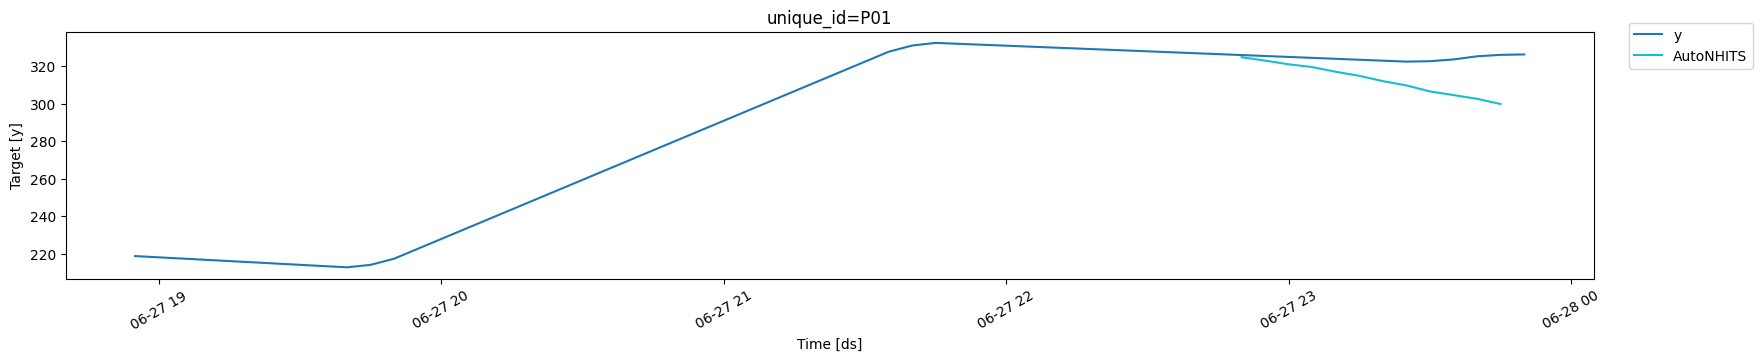

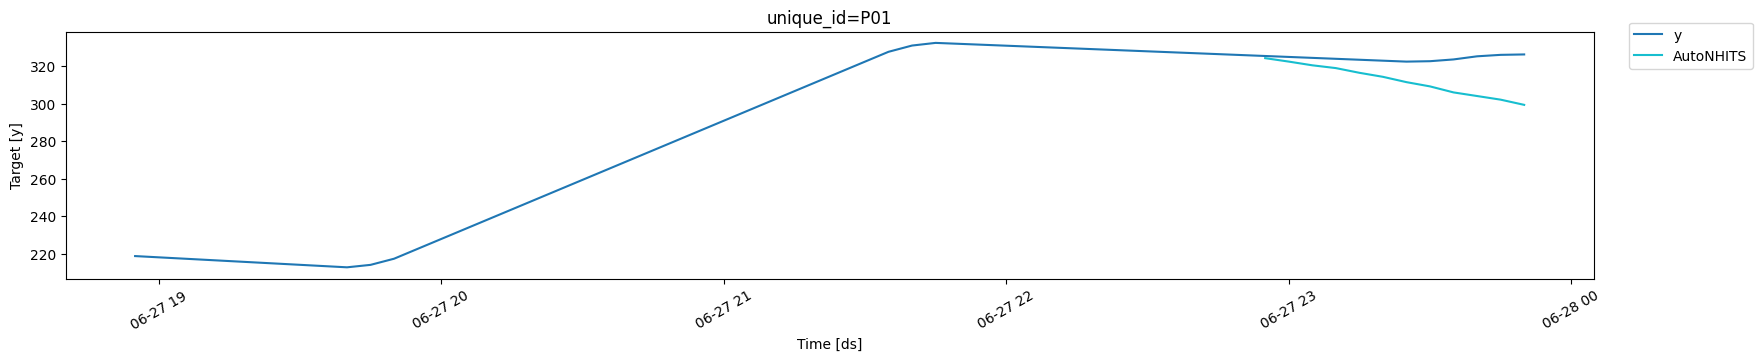

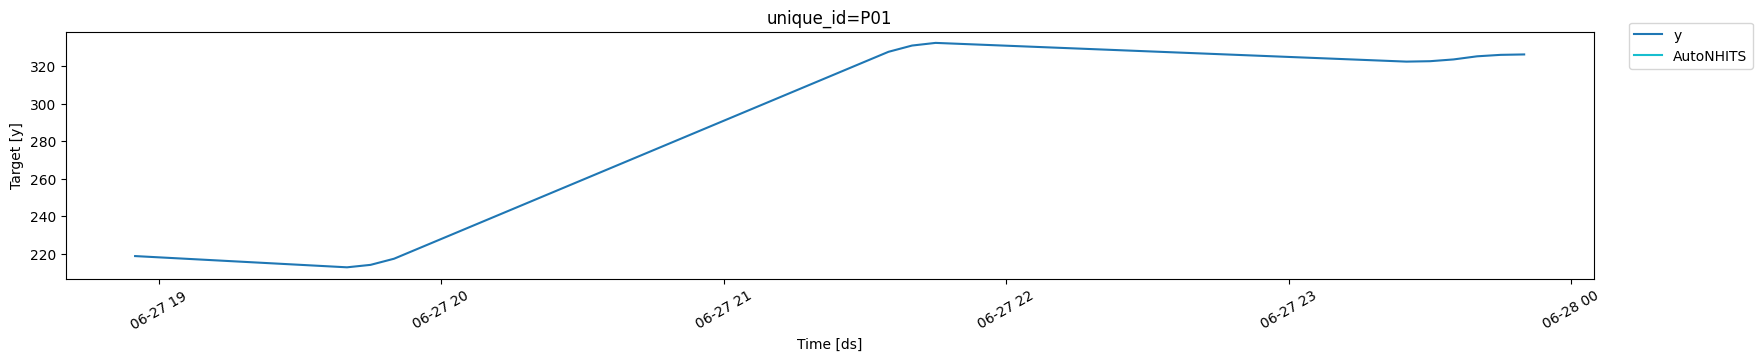

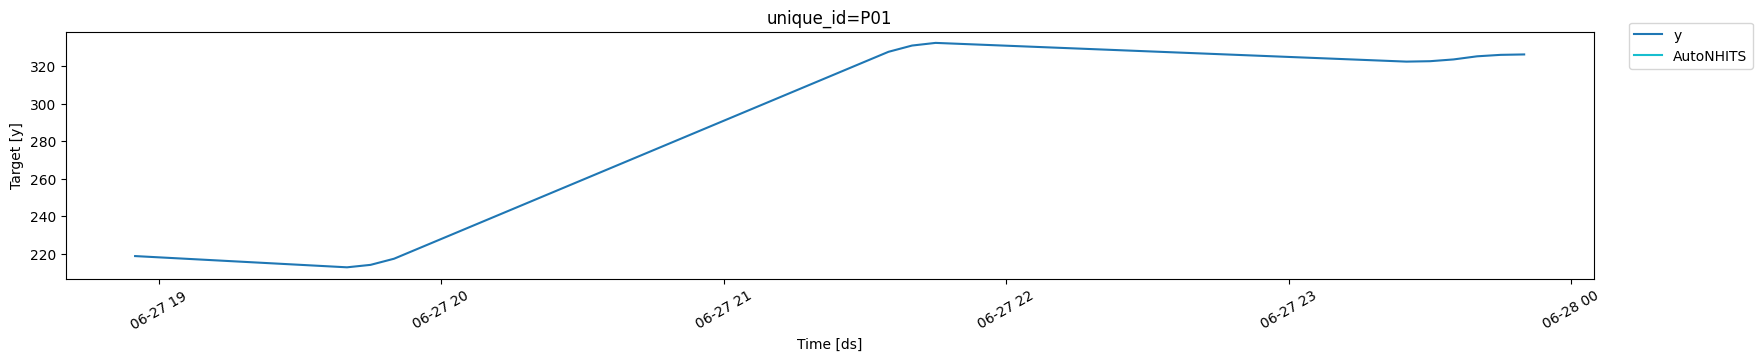

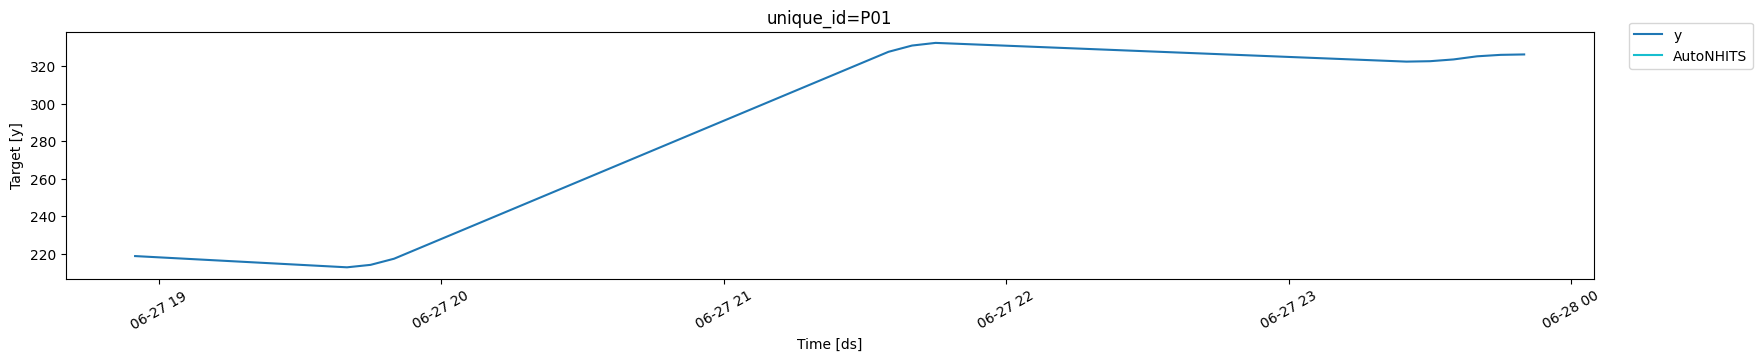

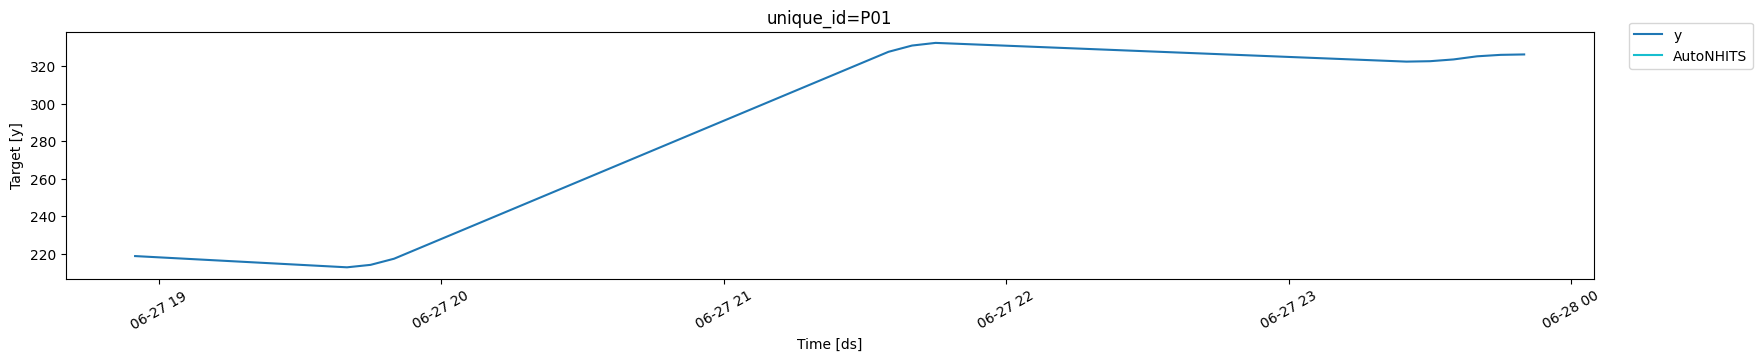

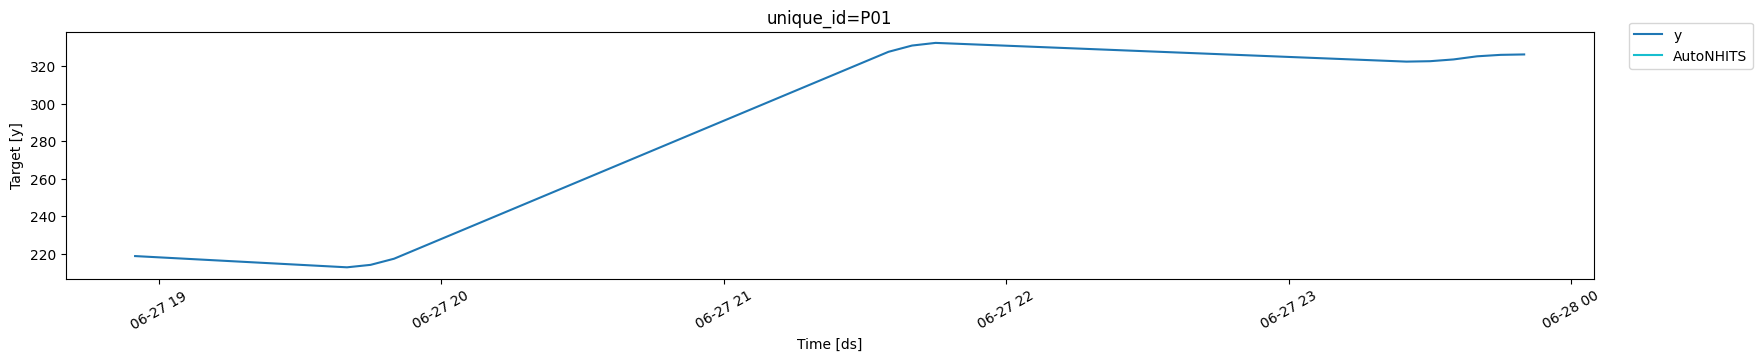

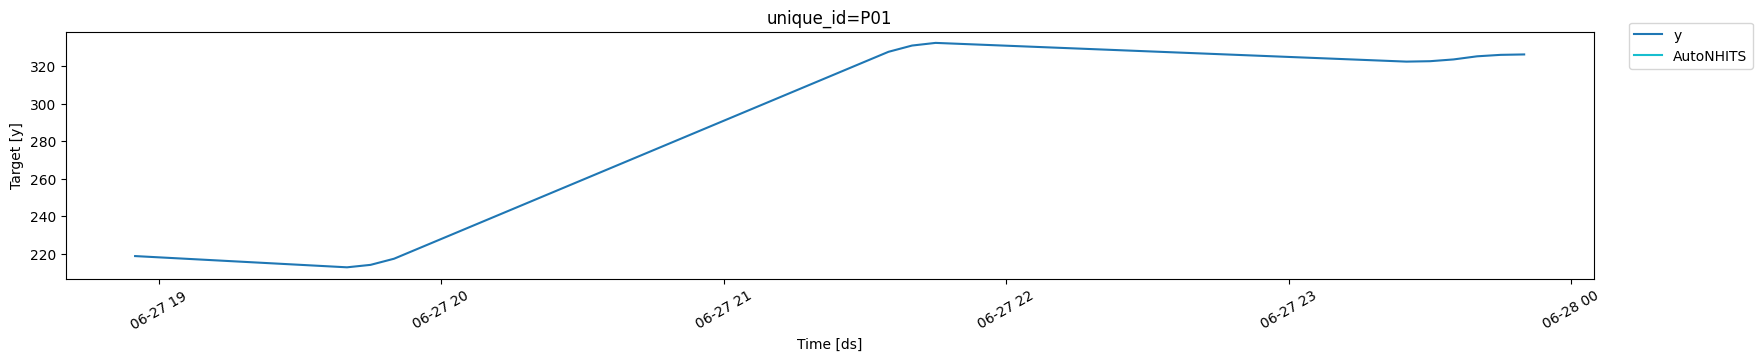

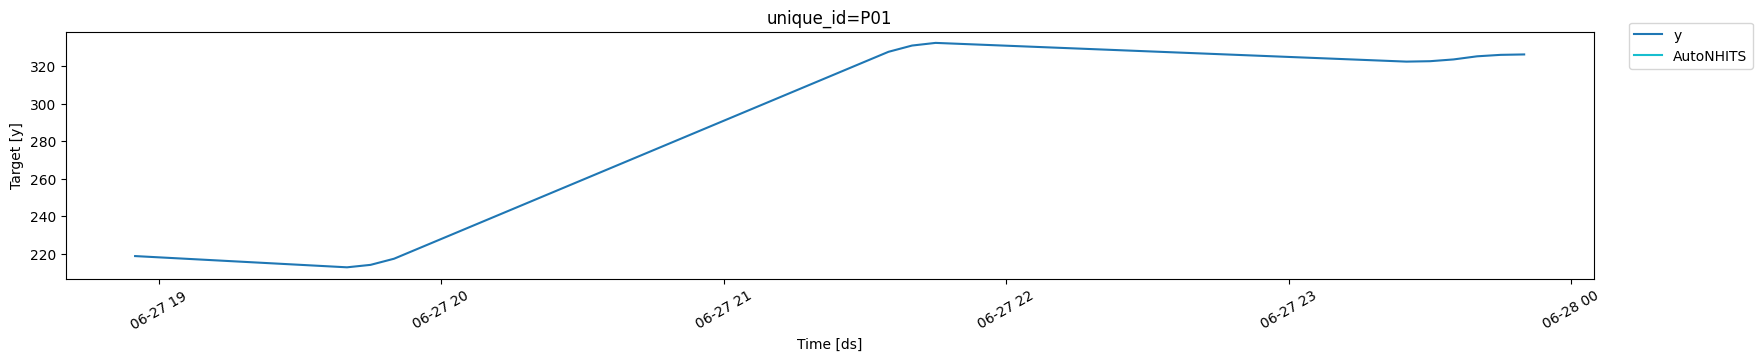

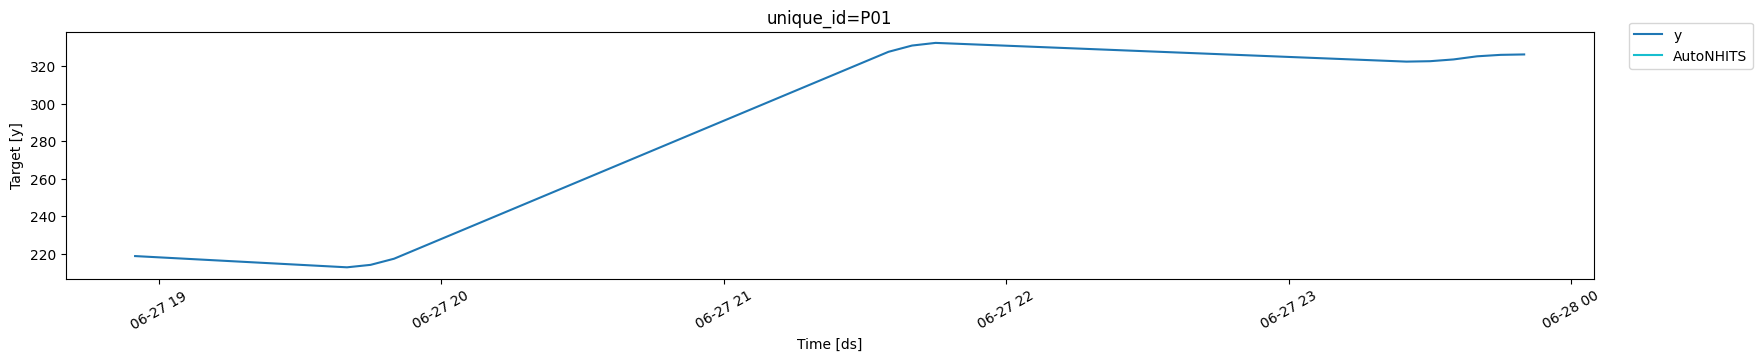

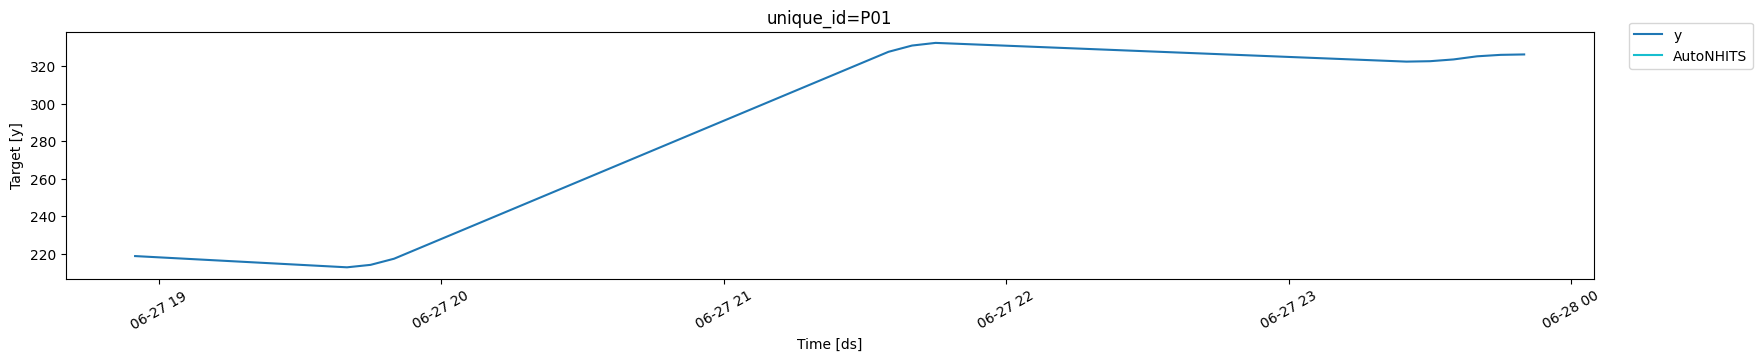

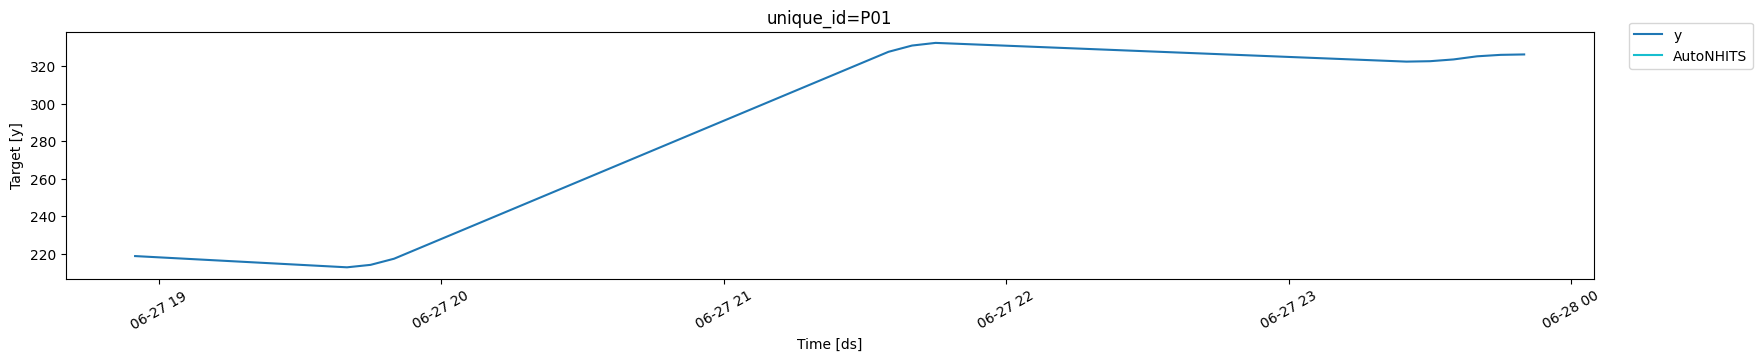

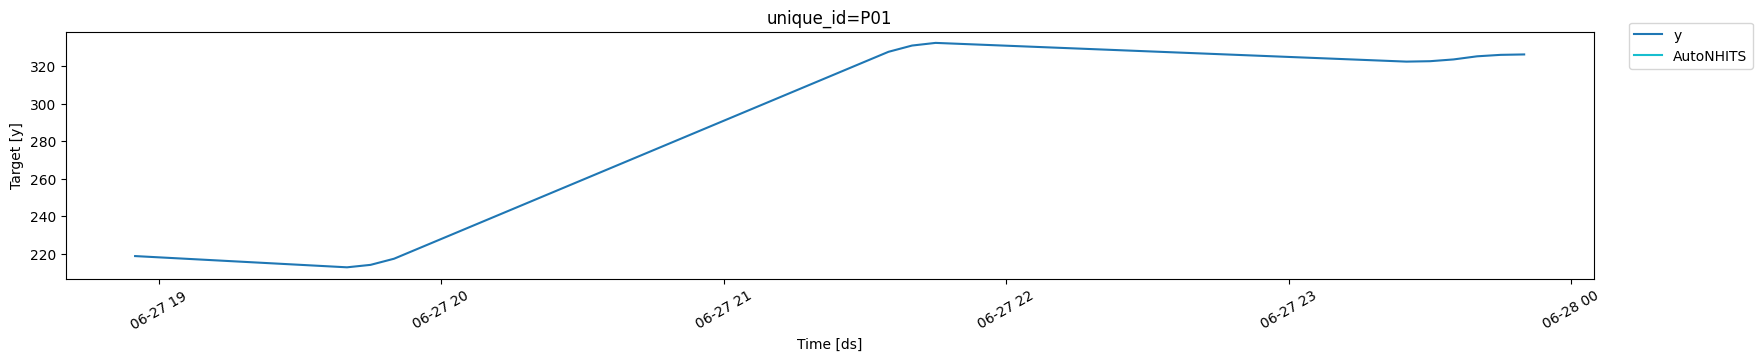

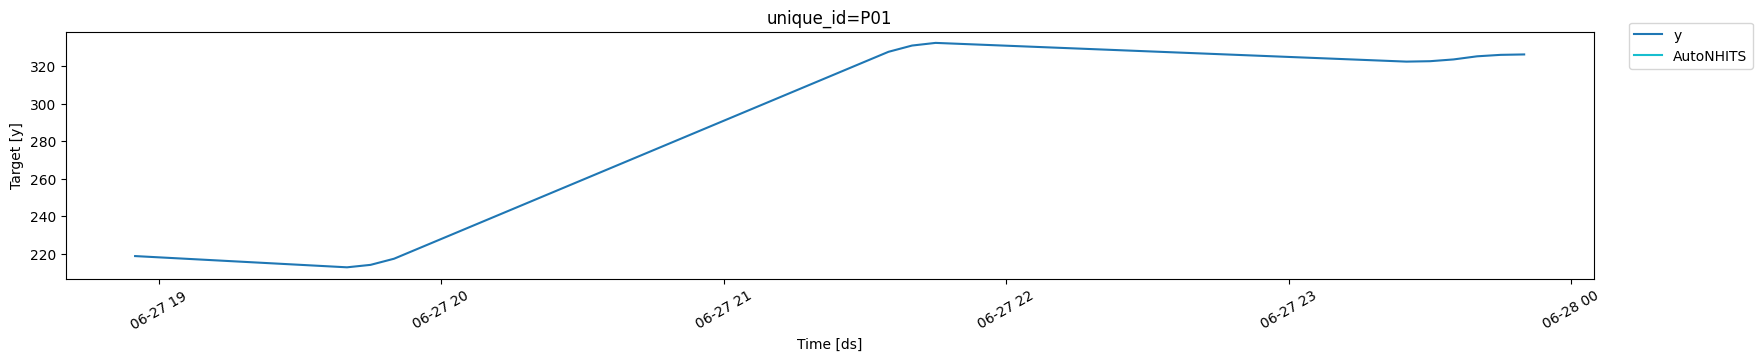

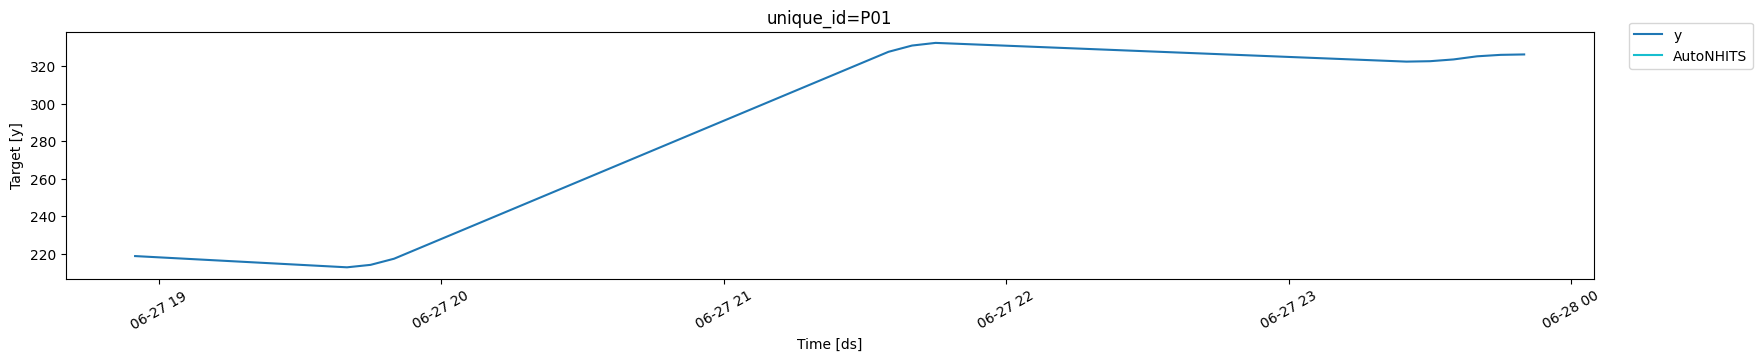

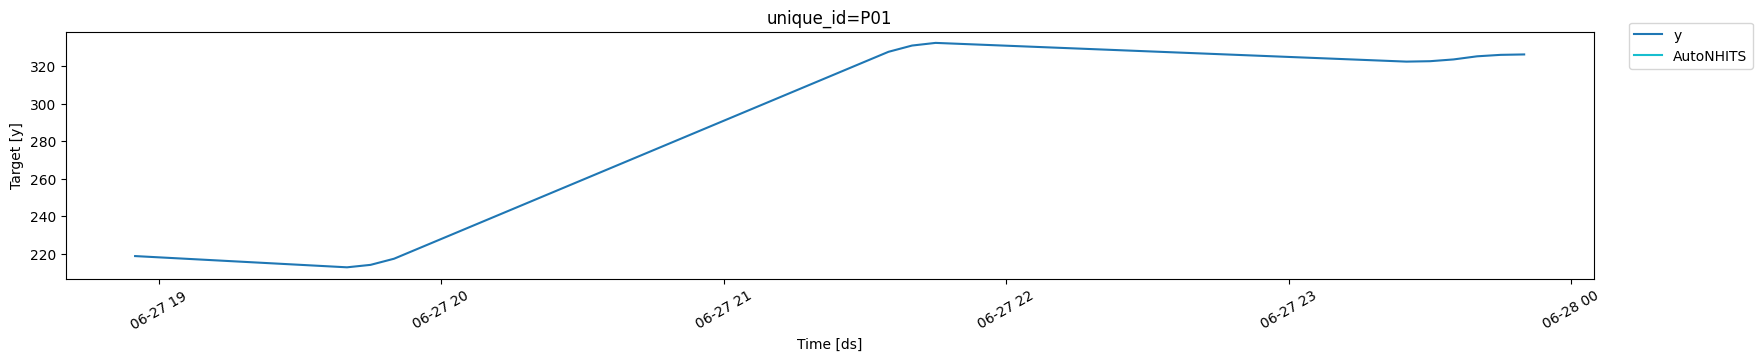

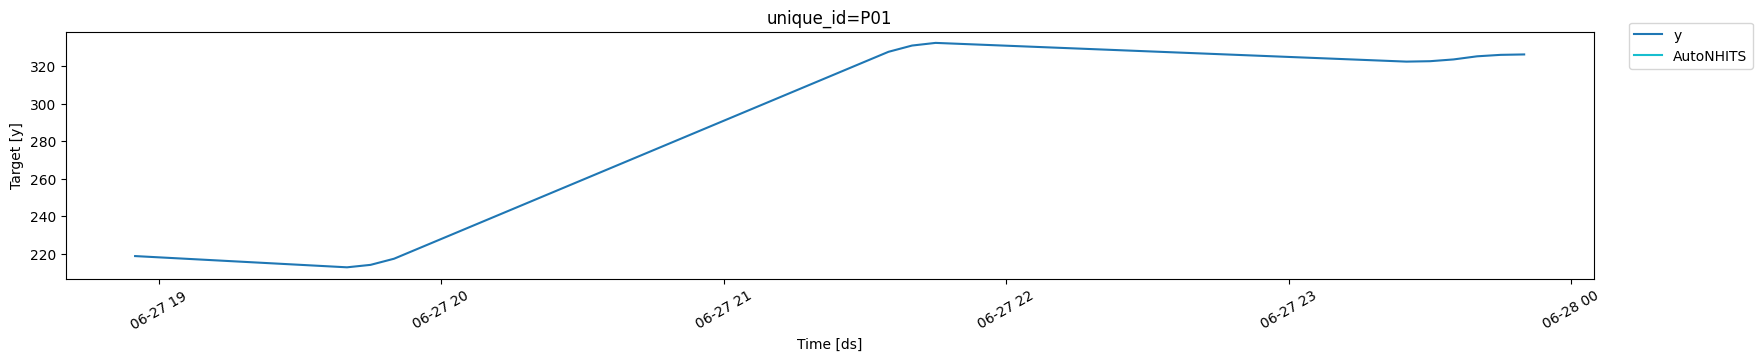

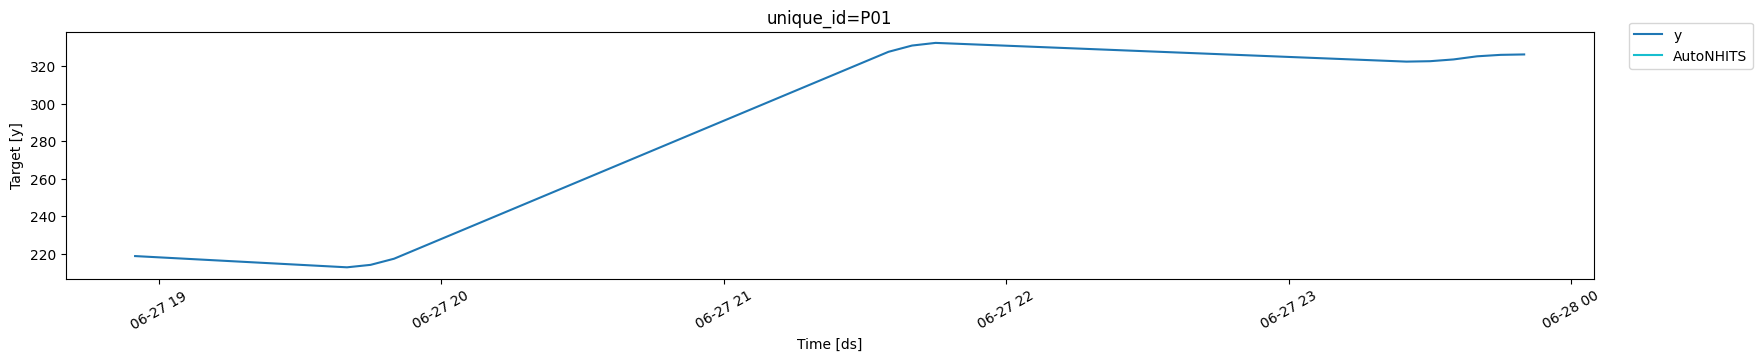

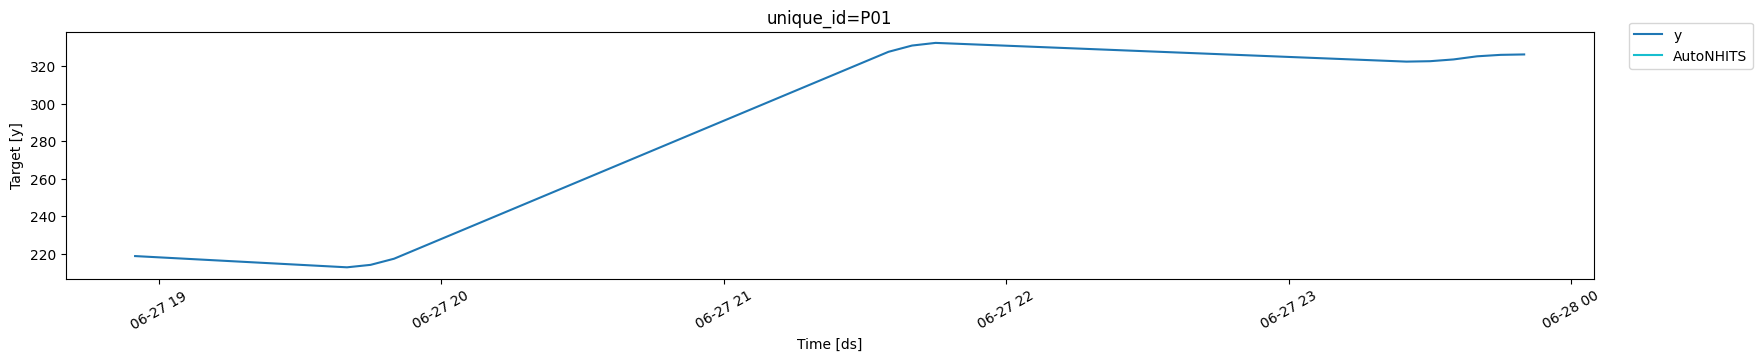

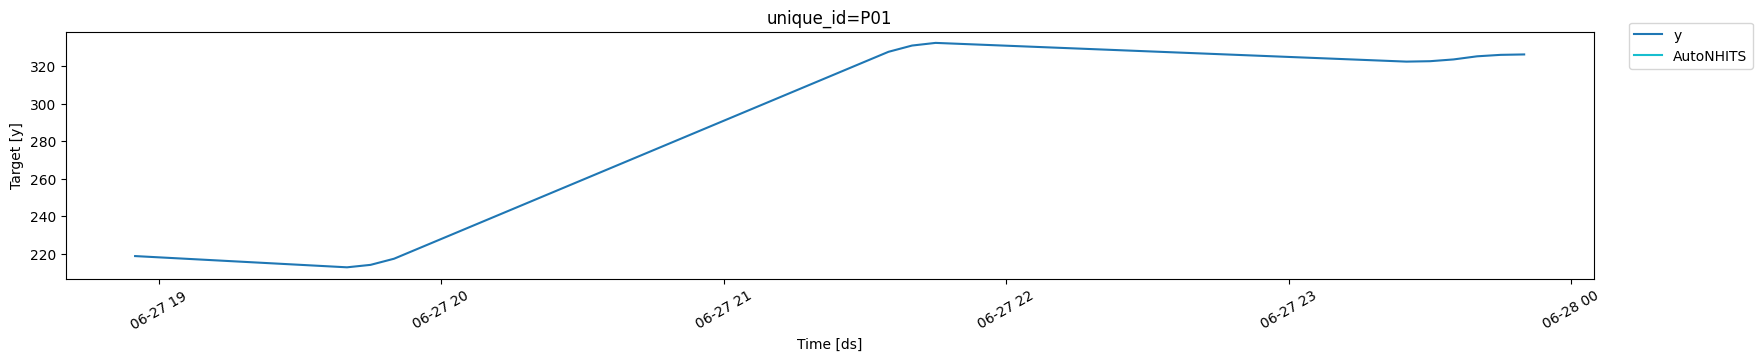

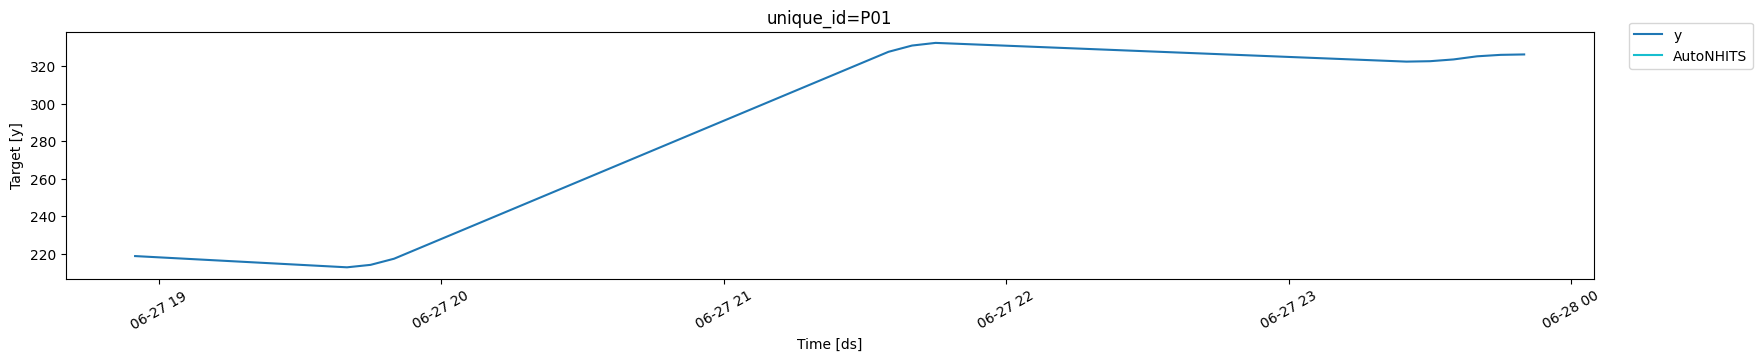

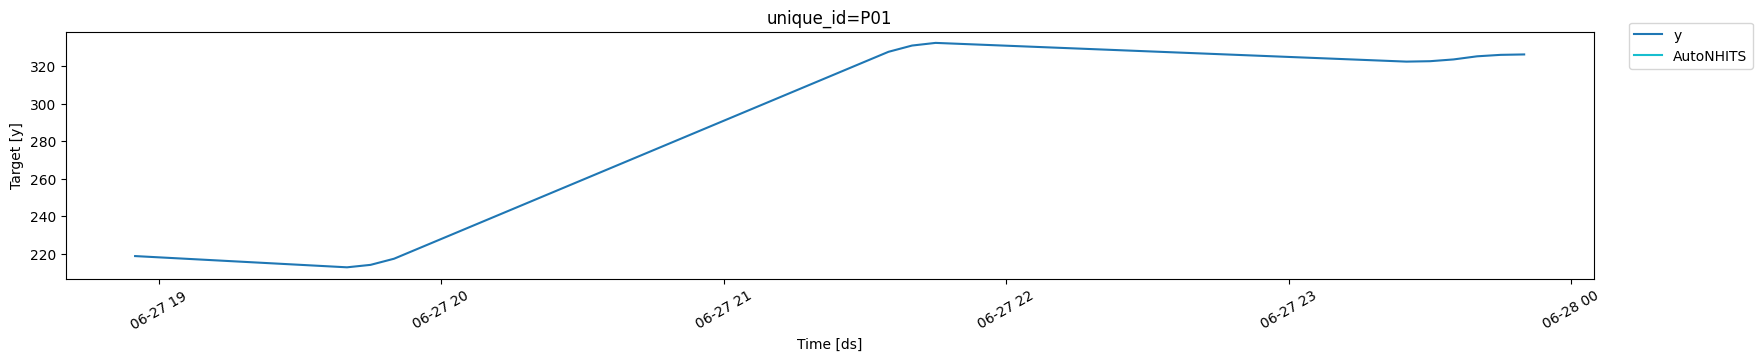

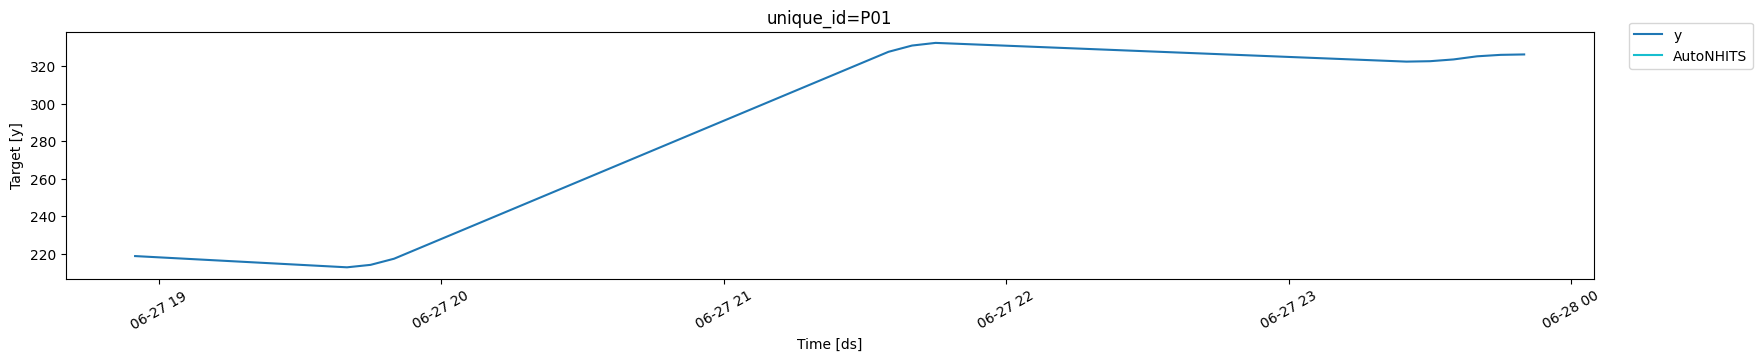

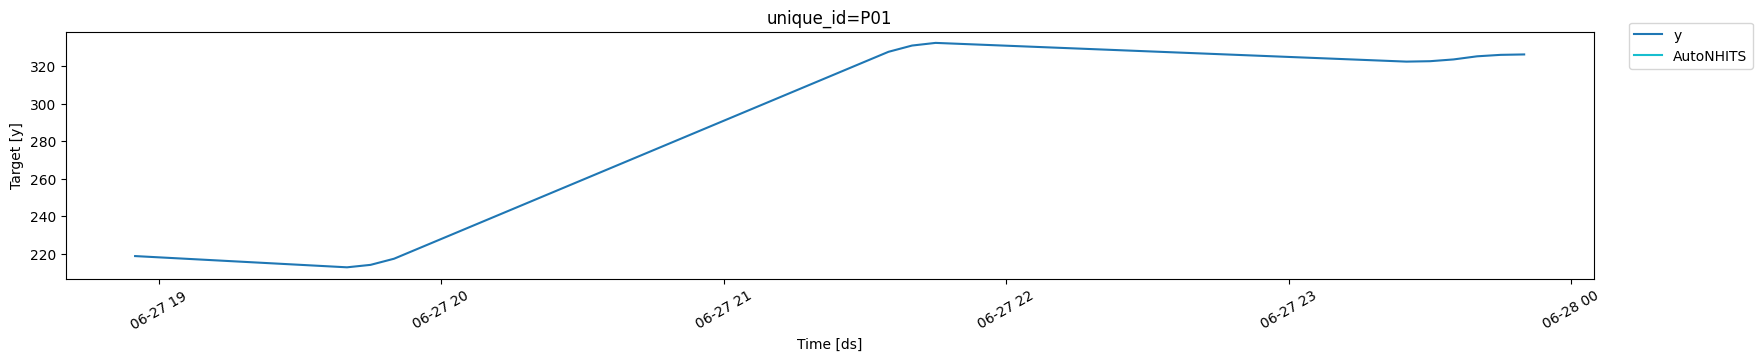

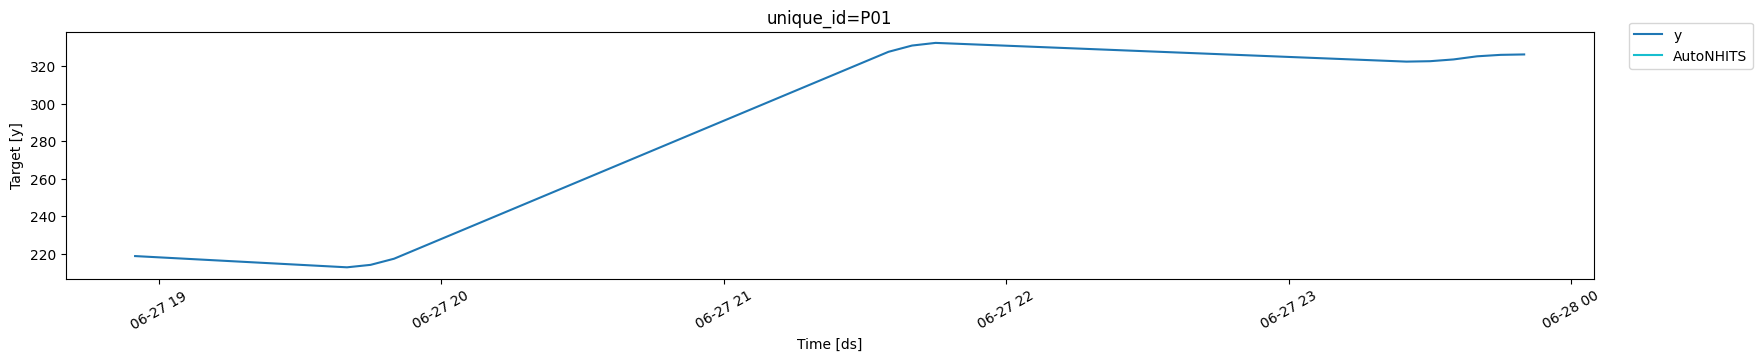

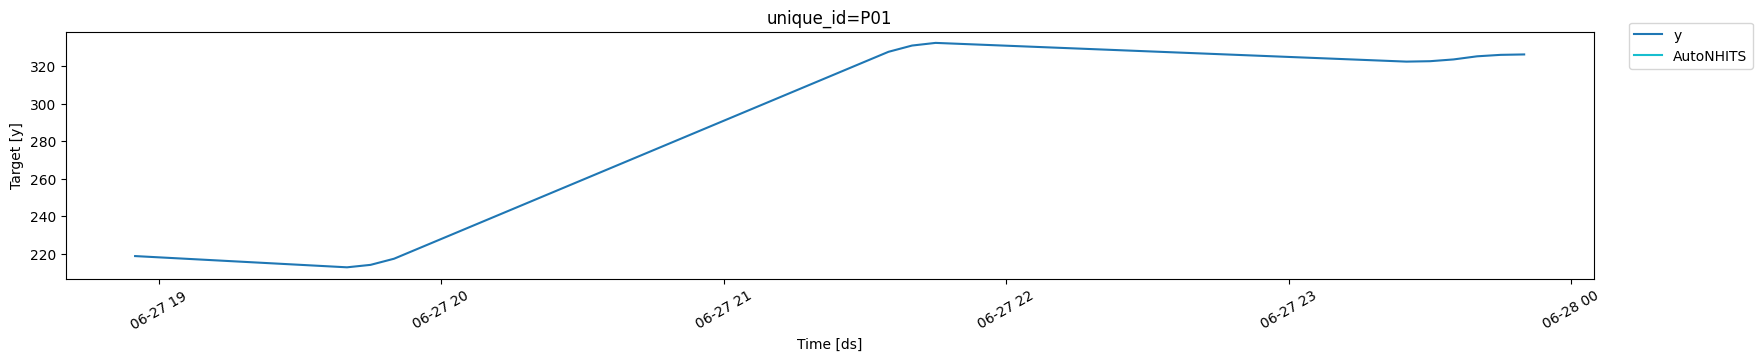

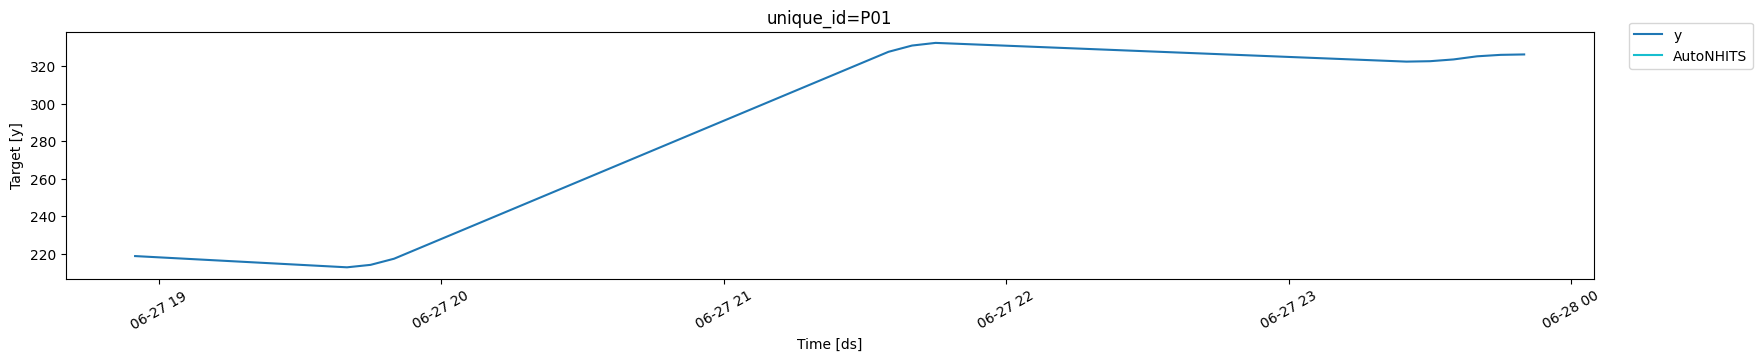

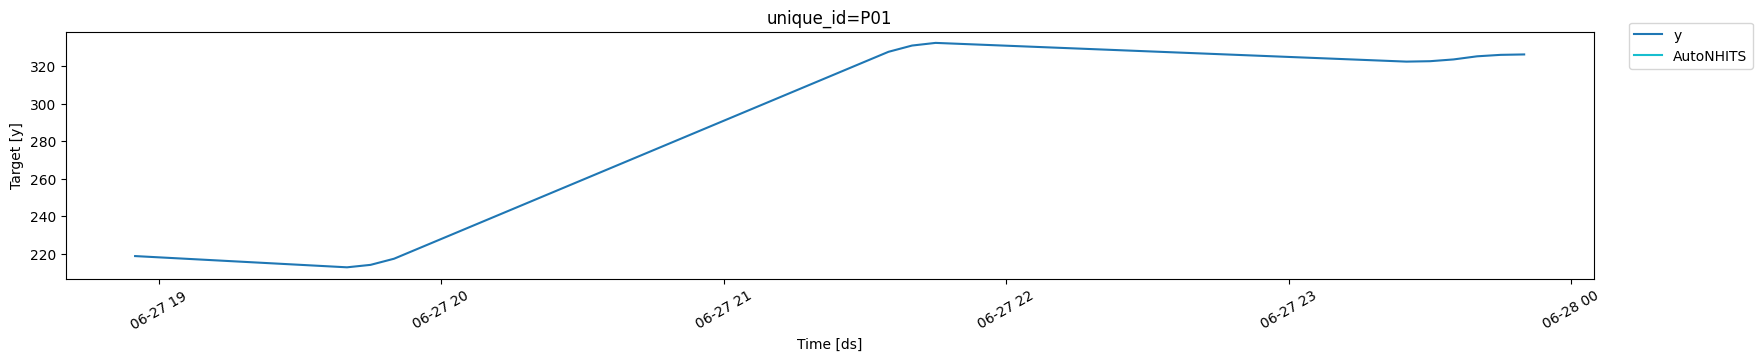

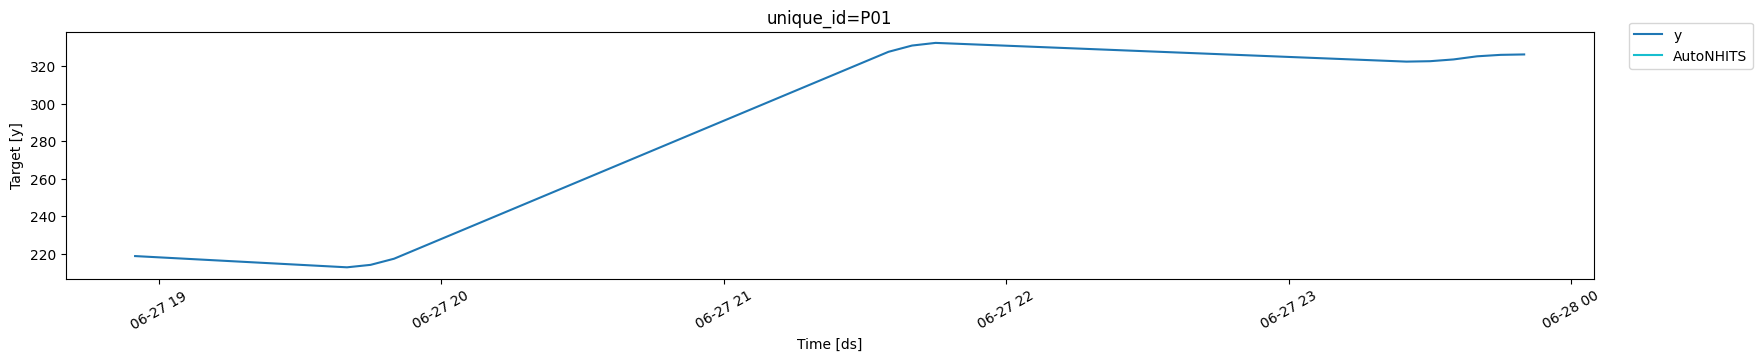

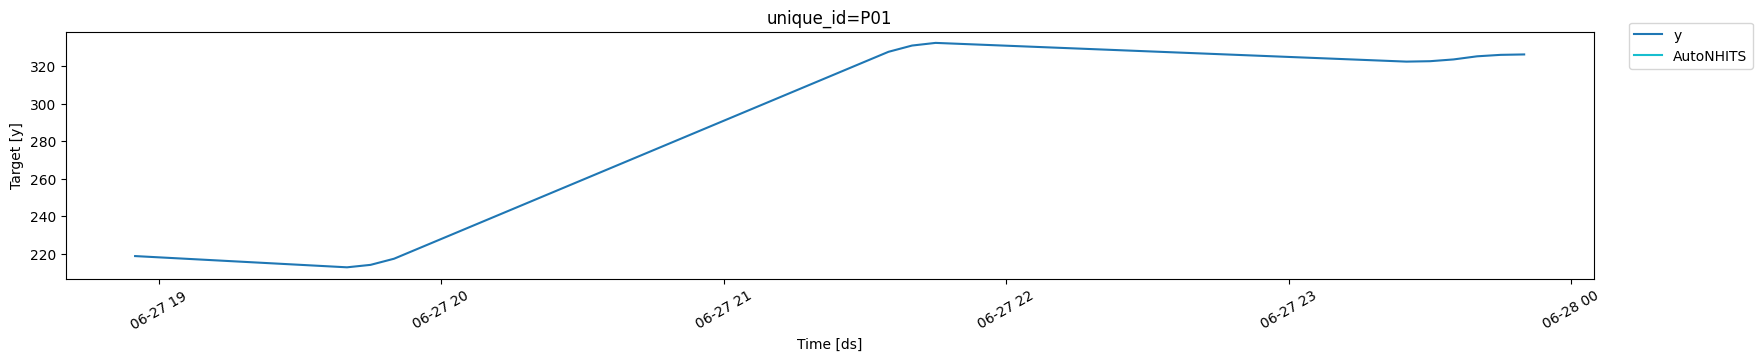

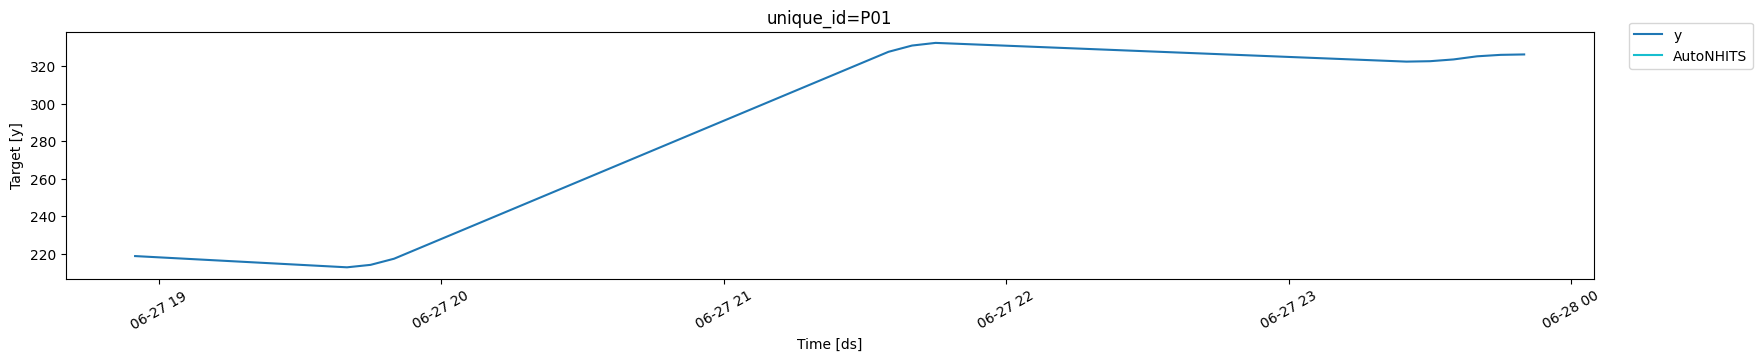

In [ ]:
#from IPython.display import display
from utilsforecast.plotting import plot_series

for cutoff in cv_df['cutoff'].unique():
    display(
        plot_series(
            train_multi_glucose,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=12 * 5,
            ids=['P01'],
        )
    )

In [ ]:
# aktuele eval

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse

evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mse, mae, rmse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()


,unique_id,metric,AutoNHITS-median,best_model
0,P01,mse,12.237472,AutoNHITS-median
1,P02,mse,233.925711,AutoNHITS-median
2,P03,mse,506.390265,AutoNHITS-median
3,P04,mse,784.317260,AutoNHITS-median
4,P05,mse,1135.980667,AutoNHITS-median


In [ ]:
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[ mse, mae, rmse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

,unique_id,metric,AutoNHITS-median,best_model
0,P01,mse,12.237472,AutoNHITS-median
1,P02,mse,233.925711,AutoNHITS-median
2,P03,mse,506.390265,AutoNHITS-median
3,P04,mse,784.317260,AutoNHITS-median
4,P05,mse,1135.980667,AutoNHITS-median


In [ ]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'nr. of unique_ids']
summary_df

,metric,model,nr. of unique_ids
0,mae,AutoNHITS-median,16
1,mse,AutoNHITS-median,16
2,rmse,AutoNHITS-median,16


Now, let's evaluate the models' performance.

In [23]:
#from datasetsforecast.losses import mse, mae, rmse
#from datasetsforecast.evaluation import accuracy

import numpy as np
import pandas as pd

# Define metrics
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))



def accuracy(cv_df, metrics, agg_by=['unique_id']):
    """
    Computes metrics (e.g., MSE, MAE, RMSE) for each model's point forecasts in the DataFrame.

    Parameters:
    - cv_df (pd.DataFrame): Input DataFrame with prediction columns, prediction intervals, and true values.
    - metrics (list): List of metric functions (e.g., [mse, mae, rmse]).
    - agg_by (list): Columns to group by and aggregate results.

    Returns:
    - pd.DataFrame: Aggregated metric results for each model and unique_id.
    """
    # Filter out columns with only point forecasts (exclude prediction intervals)
    y_col = 'y'
    forecast_cols = [col for col in cv_df.columns if col.startswith("Auto") and not any(suffix in col for suffix in ["-lo-90", "-lo-80", "-hi-80", "-hi-90"])]

    results = []

    # Group by specified columns (e.g., 'unique_id')
    grouped = cv_df.groupby(agg_by)

    for group_name, group_df in grouped:
        y_true = group_df[y_col].values

        for metric in metrics:
            metric_name = metric.__name__
            metric_results = {metric_name: metric(y_true, group_df[forecast_col].values) for forecast_col in forecast_cols}
            metric_results.update({col: group_name for col in agg_by})
            results.append(metric_results)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Reshape results for each metric
    metric_dfs = []
    for metric in metrics:
        metric_name = metric.__name__
        metric_df = results_df[[metric_name] + forecast_cols + agg_by].copy()
        metric_df = metric_df.rename(columns={metric_name: "metric"})
        metric_df["metric"] = metric_name
        metric_dfs.append(metric_df)

    # Combine all metrics
    evaluation_df = pd.concat(metric_dfs, axis=0)

    return evaluation_df



In [ ]:
# THE CORRECT WAY WITHOUT ACCURACY FUCTION https://nixtlaverse.nixtla.io/neuralforecast/docs/tutorials/cross_validation.html

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse

# Long-Horizon Forcast

In [19]:
from datasetsforecast.long_horizon import LongHorizon
from statsforecast import StatsForecast


In [ ]:
# Rename the columns to fit the desired format
train_p27_renamed = train_p27.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})

# Display the transformed DataFrame
#print(train_p27_renamed[['unique_id','ds', 'y' ]])
train_p27_glucose=train_p27_renamed[['unique_id','ds', 'y' ]]


# Rename the columns to fit the desired format
test_p27_renamed = test_p27.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})

# Display the transformed DataFrame
#print(train_p27_renamed[['unique_id','ds', 'y' ]])
test_p27_glucose=test_p27_renamed[['unique_id','ds', 'y' ]]

In [ ]:
train_multi_glucose['unique_id'].unique()

array(['P01', 'P02', 'P03', 'P04', 'P05', 'P14', 'P16', 'P17', 'P19',
       'P20', 'P22', 'P23', 'P24', 'P25', 'P26', 'P28'], dtype=object)

In [ ]:
test_multi_glucose['unique_id'].unique()

array(['P06', 'P07', 'P11', 'P15', 'P18', 'P21'], dtype=object)

In [ ]:
Y_df = pd.concat([train_p27_glucose, test_p27_glucose])#train_multi_glucose
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,P27,2020-06-26 22:15:00,112.0
1,P27,2020-06-26 22:20:00,105.0


In [ ]:
n_time, val_size, test_size

(150645, 30129, 30129)

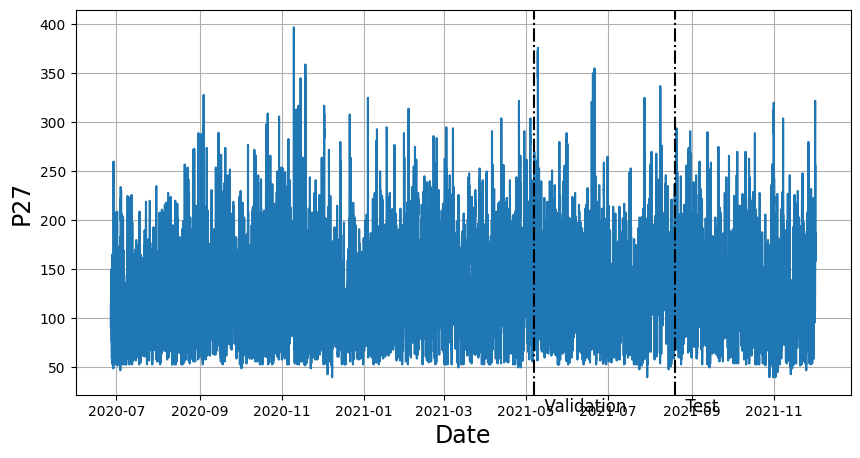

In [ ]:
import matplotlib.pyplot as plt

# We are going to plot the temperature of the transformer
# and marking the validation and train splits
u_id = 'P27'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot.iloc[n_time - val_size - test_size]
x_test = x_plot.iloc[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('P27', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()

In [ ]:
from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

In [ ]:
horizon = 12 # 1h.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

In [ ]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config,
                    num_samples=5)]

In [ ]:
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

2025-01-28 12:01:47,115	INFO worker.py:1841 -- Started a local Ray instance.
2025-01-28 12:01:50,675	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-01-28_12-01-43   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-01-28_12-01-43
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-28_12-01-43_972702_251/artifacts/2025-01-28_12-01-50/_train_tune_2025-01-28_12-01-43/driver_artifacts`


(pid=3294) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=3294) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=3294) 
(pid=3294) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=3294) This will raise in a future version.
(pid=3294) 
(pid=3294)   warnings.warn(msg, FutureWarning)
(_train_tune pid=3294) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=3294) Seed set to 7
(_train_tune pid=3294) GPU available: False, used: False
(_train_tune pid=3294) TPU available: False, using: 0 TPU cores
(_train_tune pid=3294) HPU available: False, using: 0 HPUs
(_train_tune pid=3294) 2025-01-28 12:02:01.944350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, v_num=0, train_loss_step=13.50, train_loss_epoch=12.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=3294) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s, v_num=0, train_loss_step=12.00, train_loss_epoch=12.30, valid_loss=12.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=3294) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, v_num=0, train_loss_step=12.40, train_loss_epoch=12.10, valid_loss=12.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=3294) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s, v_num=0, train_loss_step=12.50, train_loss_epoch=12.70, valid_loss=11.50]
Validation: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=3294) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=4779) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=4779) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=4779) 
(pid=4779) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=4779) This will raise in a future version.
(pid=4779) 
(pid=4779)   warnings.warn(msg, FutureWarning)
(_train_tune pid=4779) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4779) Seed set to 2
(_train_tune pid=4779) GPU available: False, used: False
(_train_tune pid=4779) TPU available: False, using: 0 TPU cores
(_train_tune pid=4779) HPU available: False, using: 0 HPUs
(_train_tune pid=4779) 2025-01-28 12:07:48.4353

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, v_num=0, train_loss_step=12.80, train_loss_epoch=13.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4779) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, v_num=0, train_loss_step=11.70, train_loss_epoch=12.00, valid_loss=12.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4779) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, v_num=0, train_loss_step=12.00, train_loss_epoch=12.20, valid_loss=12.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4779) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, v_num=0, train_loss_step=12.50, train_loss_epoch=11.40, valid_loss=12.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:

(_train_tune pid=4779) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=6372) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=6372) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=6372) 
(pid=6372) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=6372) This will raise in a future version.
(pid=6372) 
(pid=6372)   warnings.warn(msg, FutureWarning)
(_train_tune pid=6372) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6372) Seed set to 3
(_train_tune pid=6372) GPU available: False, used: False
(_train_tune pid=6372) TPU available: False, using: 0 TPU cores
(_train_tune pid=6372) HPU available: False, using: 0 HPUs
(_train_tune pid=6372) 2025-01-28 12:14:00.4063

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, v_num=0, train_loss_step=14.10, train_loss_epoch=11.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6372) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, v_num=0, train_loss_step=11.70, train_loss_epoch=11.60, valid_loss=12.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6372) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, v_num=0, train_loss_step=11.90, train_loss_epoch=12.90, valid_loss=12.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6372) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, v_num=0, train_loss_step=11.40, train_loss_epoch=12.20, valid_loss=11.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:

(_train_tune pid=6372) `Trainer.fit` stopped: `max_steps=1000` reached.


(_train_tune pid=6372) 
Epoch 999: 100%|██████████| 1/1 [00:03<00:00,  0.28it/s, v_num=0, train_loss_step=11.70, train_loss_epoch=11.70, valid_loss=10.90]


(pid=7832) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=7832) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=7832) 
(pid=7832) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=7832) This will raise in a future version.
(pid=7832) 
(pid=7832)   warnings.warn(msg, FutureWarning)
(_train_tune pid=7832) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7832) Seed set to 4
(_train_tune pid=7832) GPU available: False, used: False
(_train_tune pid=7832) TPU available: False, using: 0 TPU cores
(_train_tune pid=7832) HPU available: False, using: 0 HPUs
(_train_tune pid=7832) 2025-01-28 12:19:41.631715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unabl

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, v_num=0, train_loss_step=12.30, train_loss_epoch=13.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7832) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, v_num=0, train_loss_step=12.30, train_loss_epoch=11.30, valid_loss=12.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7832) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, v_num=0, train_loss_step=11.90, train_loss_epoch=12.60, valid_loss=11.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7832) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, v_num=0, train_loss_step=11.30, train_loss_epoch=11.90, valid_loss=11.60]
(_train_tune pid=7832) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  

(_train_tune pid=7832) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=9274) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=9274) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=9274) 
(pid=9274) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=9274) This will raise in a future version.
(pid=9274) 
(pid=9274)   warnings.warn(msg, FutureWarning)
(_train_tune pid=9274) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9274) Seed set to 3
(_train_tune pid=9274) GPU available: False, used: False
(_train_tune pid=9274) TPU available: False, using: 0 TPU cores
(_train_tune pid=9274) HPU available: False, using: 0 HPUs
(_train_tune pid=9274) 2025-01-28 12:25:16.2902

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s, v_num=0, train_loss_step=14.20, train_loss_epoch=11.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=9274) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s, v_num=0, train_loss_step=11.60, train_loss_epoch=11.40, valid_loss=12.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=9274) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, v_num=0, train_loss_step=11.30, train_loss_epoch=12.50, valid_loss=12.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=9274) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, v_num=0, train_loss_step=11.20, train_loss_epoch=12.00, valid_loss=11.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:

2025-01-28 12:30:46,589	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-01-28_12-01-43' in 0.0134s.
INFO:lightning_fabric.utilities.seed:Seed set to 7
(_train_tune pid=9274) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



(_train_tune pid=9274) 
Epoch 999: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=0, train_loss_step=11.80, train_loss_epoch=11.80, valid_loss=10.80]


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.044    Total estimated model params size (MB)
33        Modules in train mode
1         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
nf.models[0].results.get_best_result().config


{'learning_rate': 0.001,
 'max_steps': 1000,
 'input_size': 60,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [24, 12, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 7,
 'h': 12,
 'loss': MAE(),
 'valid_loss': MAE()}

In [ ]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (1, 30118, 12)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (1, 30118, 12)


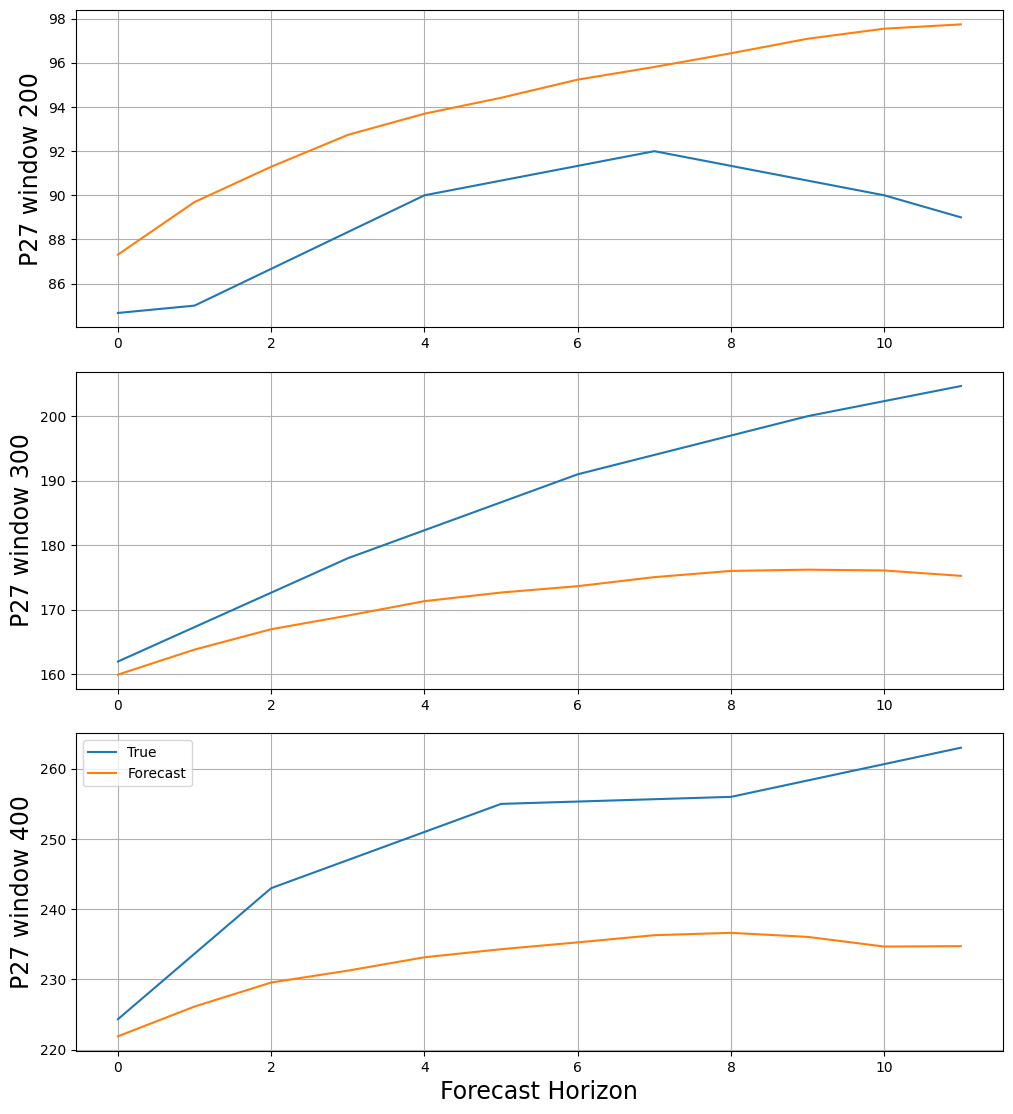

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

#series = ['HUFL','HULL','LUFL','LULL','MUFL','MULL','OT']
series_idx = 0#3
series=['P27']

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}',
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

In [ ]:
from neuralforecast.losses.numpy import mae, mse, mape

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))
print('MAPE: ', mape(y_hat, y_true))


MAE:  10.10662053705834
MSE:  258.53816328669353
MAPE:  0.08527424922379508


In [ ]:
y_hat[:, :, -1]

array([[151.0328 , 153.7192 , 140.34189, ..., 168.34749, 171.65106,
        174.16513]], dtype=float32)

In [ ]:
# Evaluation for 1h prediction

print('MAE: ', mae(y_hat[:, :, -1], y_true[:, :, -1]))
print('MSE: ', mse(y_hat[:, :, -1], y_true[:, :, -1]))
print('MAPE: ', mape(y_hat[:, :, -1], y_true[:, :, -1]))


MAE:  17.714697351875216
MSE:  614.5875309345079
MAPE:  0.14911319044882593


<ipython-input-74-f156f5dc0dc1>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start='2020-01-01 00:00', periods=500, freq='5T')  # 300 points with 5-minute intervals


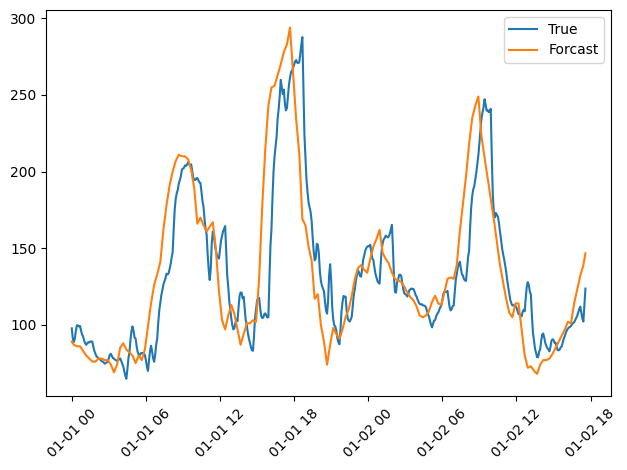

In [ ]:
time_index = pd.date_range(start='2020-01-01 00:00', periods=500, freq='5T')  # 300 points with 5-minute intervals

plt.plot(time_index,y_hat[0, 200:700, -1],label='True')
plt.plot(time_index,y_true[0, 200:700, -1],label='Forcast')
plt.legend()
plt.xticks(rotation=45)  # Rotate the time labels for better readability
plt.tight_layout()
plt.show()

Note: yes, this is chaos